<a href="https://colab.research.google.com/github/dovahkiin0022/dummy_group_repositiory/blob/Chengyin/AFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')
drive_prefix = '/content/drive/MyDrive/FullDataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import os
import glob


# WR: this is my path:
drive_prefix = '/content/drive/MyDrive/FullDataset'

all_files = glob.glob(os.path.join(drive_prefix, '*', '*.tif'))
print(f'found {len(all_files)} tif files in Drive')

found 231 tif files in Drive


In [19]:
pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import pickle
import numpy as np
from sklearn import decomposition
from plotly import express as px
from matplotlib import pyplot as plt
from PIL import Image
import os
from scipy import ndimage
import pandas as pd
import requests
import zipfile
import sklearn
import json
import os.path
from scipy import stats, signal, ndimage, interpolate
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, show
from numpy.linalg import norm 
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator

def rgb_to_lightness(im):
    """Implement the lightness transform found here:
    https://stackoverflow.com/questions/596216/formula-to-determine-perceived-brightness-of-rgb-color
    """
    R, G, B = np.array(im).transpose([2, 0, 1])  # get each color channel
    L = (0.299 * R + 0.587 * G + 0.114 * B)  # one possible formula for luminance
    
    return L


def autocrop(afm):
    # convert to lightness only
    L = rgb_to_lightness(afm)
    # find bounds
    afm_bounds = np.zeros(4, dtype=int)
    for i in range(2):
        min_pixels = np.argwhere(L.min(axis=i) < L.max()).flatten()
        gap_idx = np.argwhere(np.diff(min_pixels) > 1).flatten()[0]
        min_pixels = min_pixels[:gap_idx]
        if len(min_pixels) < 1:
            min_pixels = [L.shape[i]]

        median_pixels = np.argwhere(np.median(L, axis=i) < L.max()).flatten()
        if len(median_pixels) < 1:
            median_pixels = [L.shape[i]]

        afm_bounds[0 + i] = min(min_pixels[0], median_pixels[0])
        afm_bounds[2 + i] = min(min_pixels[-1], median_pixels[-1])

    return afm.crop(box=afm_bounds)


def smooth_histogram(L):
    x = np.arange(0, 255)
    delta = 0.5*np.diff(x)[0]
    x_edge = np.hstack([x - delta, x[-1]+delta])
    yh, xh = np.histogram(L[np.logical_and(L>0, L<255)], bins=x_edge, density=True)
    xc = 0.5 * (xh[1:] + xh[:-1])
    yh = ndimage.gaussian_filter(yh, 6)
    L = np.delete(L,np.argwhere(L>=254))
    return xc, yh


def get_coverage(L, L_star):
    L = np.delete(L,np.argwhere(L>=254))
    x = np.arange(0, 255)
    delta = 0.5*np.diff(x)[0]
    x_edge = np.hstack([x - delta, x[-1]+delta])
    yh, xh = np.histogram(L, bins=x_edge)
    coverage = 1 - np.cumsum(yh)/np.sum(yh)
    man_Lthres = L_star
    man_Lthres = np.array(man_Lthres).astype(int)
    all_c = []
    for i in man_Lthres:
      pre_c = interpolate.interp1d(x, coverage)([i]).tolist()
      all_c.append(pre_c)
    #print(f'L_star of {man_Lthres} gives coverage of {pre_c}')
    #ax.plot(man_Lthres, man_c, 'rs')
    print(all_c)
    return x, coverage, all_c

url = 'https://pennstateoffice365-my.sharepoint.com/:u:/g/personal/wfr5091_psu_edu/EXfY0Qt9qKJFiHvyVd7Rx7gBbale5WiFnas19qHZ-hEYHw?e=pU7vQY'
r = requests.get(url + '&download=1')
with open('data.pkl', 'wb') as fid:
    for chunk in r.iter_content(chunk_size=8192): 
        fid.write(chunk)

with open('data.pkl', 'rb') as fid:
    coverage_data = pickle.load(fid)

coverage_keys = list(coverage_data.keys())
l_curves = np.array([coverage_data[k]['lightness'] for k in coverage_keys])
coverage_est = np.array([val['coverage'][val['estimates']['min']] for val in coverage_data.values()])

In [21]:
def BIC(L):
  fig, ax = plt.subplots()
  def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

  n_clusters=np.arange(1, 6)
  n_samples = 20000
  bics=[]
  bics_err=[]
  iterations=10
  for n in n_clusters:
      tmp_bic=[]
      for _ in range(iterations):
          rng = np.random.default_rng(seed=0)
          subL = L[rng.choice(np.arange(len(L)), n_samples)].reshape(-1, 1)
          gm= GaussianMixture(n, n_init=2).fit(subL)        
          tmp_bic.append(gm.bic(subL))
      val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
      err=np.std(tmp_bic)
      bics.append(val)
      bics_err.append(err)


  print(bics[0])

  plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
  plt.title("BIC Scores", fontsize=20)
  plt.xticks(n_clusters)
  plt.xlabel("N. of clusters")
  plt.ylabel("Score")
  plt.legend()
  return n_clusters, bics 

In [22]:
def knee(n_clusters, bics):
  from kneed import KneeLocator
  #use Kneed to find the elbow point from BIC score to determine n_components
  kn = KneeLocator(n_clusters, bics, curve='convex', direction='decreasing')
  n_components = kn.knee
  n = kn.knee
  if n_components == 1 or kn.knee == None:
    n_components = 2
    n = 1
    return n_components, n
  print(n_components)
  return n_components, n


In [23]:

#fit GMM to the data
def sample_and_fit(L, n_components, n_samples = 20000):
  rng = np.random.default_rng(seed=0)
  subL = L[rng.choice(np.arange(len(L)), n_samples)].reshape(-1, 1)
  gm = GaussianMixture(n_components, random_state=0, covariance_type='full', weights_init= None, means_init=None).fit(subL)
  #print(subL)
  return gm, subL
#gm, subL = sample_and_fit(L, n_components)

In [24]:
def pltpeak(gm, L, n_components, filename):
  fig, ax = plt.subplots()
  for x in range(0, n_components):
    mean_x = gm.means_[x][0] 
    std_x = np.sqrt(gm.covariances_[x][0][0])
    weight_x = gm.weights_[x]
    val, bins, _ = plt.hist(L, bins=100, color = 'b', edgecolor = 'white', density=False)
    area = sum(np.diff(bins)*val)  +  sum(np.diff(bins)*val)
    x = np.linspace(0, 255)
    y = stats.norm.pdf(x, mean_x, std_x)*weight_x*area   
    ax.plot(x,y)
    ax.set_title(f'{filename}')
  return x, y
#p = pltpeak(gm, L, n_components)

In [25]:
def evaluate(gm):
  gm_x=np.linspace(0, 255).reshape(-1, 1)
  gm_y = np.exp(gm.score_samples(gm_x))
  return gm_x, gm_y
#gm_x, gm_y = evaluate(gm)

In [26]:
def mixture_intersection(gm, n_components):
    from itertools import combinations
    clusters = np.arange(0, n_components)
    res = list(combinations(clusters, 2))
    L_star = []
    for a, b in res:      
      def intersection(gm):
        try:
          x = np.linspace(gm.means_[a][0], gm.means_[b][0])       
          dstns = [gm.weights_[i] * stats.norm(gm.means_[i], np.sqrt(gm.covariances_[i])).pdf(x) for i in (a , b)]
          f = (dstns[1]-dstns[0]).flatten()
          # find number of zero-crossings
          neg = (f < 0).astype(int)
          cross = np.argwhere(np.abs(neg[1:] - neg[:-1]) == 1).flatten()
          L_star.append(x[cross[0]])         
        except IndexError:
          x = np.linspace(5, 250)       
          dstns = [gm.weights_[i] * stats.norm(gm.means_[i], np.sqrt(gm.covariances_[i])).pdf(x) for i in (a , b)]
          f = (dstns[1]-dstns[0]).flatten()
          # find number of zero-crossings
          neg = (f < 0).astype(int)
          cross = np.argwhere(np.abs(neg[1:] - neg[:-1]) == 1).flatten()
          L_star.append(x[cross[0]])   
        return x[cross[0]]

      print(intersection(gm))
    return L_star
    return

#L_star = mixture_intersection(gm, n_components)
#print(L_star)

In [27]:
def applyGMM(L, filename):
  n_clusters, bics = BIC(L)
  n_components, n =knee(n_clusters, bics)
  gm, subL = sample_and_fit(L, n_components)
  x, y = pltpeak(gm, L, n_components, filename)
  gm_x, gm_y = evaluate(gm)
  L_star = mixture_intersection(gm, n_components)
  #print(L_star)
  return L_star, bics, n_components, gm, n

In [28]:
def scale():
  from tqdm import notebook
  import pytesseract


  for filename in notebook.tqdm(all_files):#.crop(crop_rectangle)
    IMG_SIZE= 1200
    crop_rectangle = (920, 0, 1200, 1200)
    afm = Image.open(os.path.join(drive_prefix, filename)).resize((IMG_SIZE, IMG_SIZE))
    extractedInformation = pytesseract.image_to_data(afm.crop(crop_rectangle), config = '-c tessedit_char_whitelist=-0123456789.  --psm 12', output_type= 'data.frame')
    a.append(float(extractedInformation['text'][4]))
    b.append(float(extractedInformation['text'][8]))
    return
  return a, b

In [29]:
!sudo apt update
!sudo add-apt-repository ppa:alex-p/tesseract-ocr-devel
!sudo apt install -y tesseract-ocr

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/alex-p/tesseract-ocr-devel/ubuntu bionic InRelease
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [3,294 kB]
Hit:13 http://ppa.launchpad.ne

In [30]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/231 [00:00<?, ?it/s]

/content/drive/MyDrive/FullDataset/MCV2-211022A-TM_211025/Edge.0_00000_1.spm.tif
-59854.960462942654
2
0.041615799012353974
[[0.00019075260353162982]]
/content/drive/MyDrive/FullDataset/MCV2-211022A-TM_211025/Edge.0_00001_1.spm.tif
-50458.447376318676
3
0.04559153654603616
0.10994951611980058
0.048921701350088324
[[0.0009042169173777426], [0.0009042169173777426], [0.0009042169173777426]]
/content/drive/MyDrive/FullDataset/MCV2-211022A-TM_211025/Center.0_00001_1.spm.tif
-16488.74156518977
2
0.4492685074281112
[[0.017205292844726716]]
/content/drive/MyDrive/FullDataset/MCV2-211022A-TM_211025/Center.0_00000_1.spm.tif
-25810.277438939138
3
0.049116173848003375
0.04383099171618862
0.35559220998023083
[[0.007295994441147147], [0.007295994441147147], [0.007295994441147147]]
/content/drive/MyDrive/FullDataset/MCV2-211102A-TM_211103/Edge.0_00000_1.spm.tif
19957.277759001026
2
0.0946178124466813
[[0.061506475399373595]]
/content/drive/MyDrive/FullDataset/MCV2-211102A-TM_211103/Center.0_00000_1.s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


-89682.86515219012
4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


0.08746680899848536
0.039684488629466386
0.07796180095163728
0.04654769227053103
0.11294877869665061
0.04480242988306226
[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
/content/drive/MyDrive/FullDataset/MCV2-211027A-TM_211028/Edge.0_00000_1.spm.tif


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


-88243.88982260395
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


0.04035484042844982
0.04289727357490229
0.0960844216339241
[[0.0], [0.0], [0.0]]
/content/drive/MyDrive/FullDataset/MCV2-211027A-TM_211028/Center.0_00001_1.spm.tif


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


6445.911529734041
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


0.4213475089206852
0.057037317731323284
0.08617040743510629
[[0.03951746986028537], [0.03951746986028537], [0.03951746986028537]]
/content/drive/MyDrive/FullDataset/MCV2-211105A-TM_211108/Edge.0_00000_1.spm.tif


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


-64318.18357455549
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


0.054916078045719234
[[0.0]]
/content/drive/MyDrive/FullDataset/MCV2-211105A-TM_211108/Edge.0_00001_1.spm.tif


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


-73685.10324666798
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


0.05003664404413695
0.11165099223816619
0.06245586022394601
[[0.0], [0.0], [0.0]]
/content/drive/MyDrive/FullDataset/MCV2-211105A-TM_211108/Center.0_00000_1.spm.tif


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


-423.70376711145724
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


0.06680944980484971
[[0.029653761133958456]]
/content/drive/MyDrive/FullDataset/MCV2-211105A-TM_211108/Center.0_00003_1.spm.tif


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


-2534.4990808986063
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


0.07295718763924483
[[0.02968704515963505]]
/content/drive/MyDrive/FullDataset/MCV2-211105A-TM_211108/Center.0_00001_1.spm.tif


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


-3046.5430073826305
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


0.07756179426964546
[[0.0273804647300111]]
/content/drive/MyDrive/FullDataset/MCV2-211105A-TM_211108/Center.0_00002_1.spm.tif


ValueError: ignored

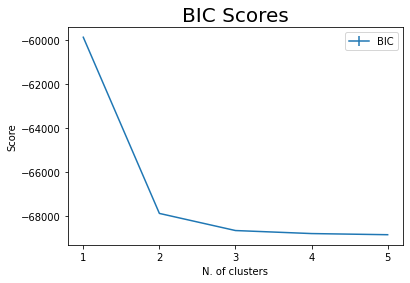

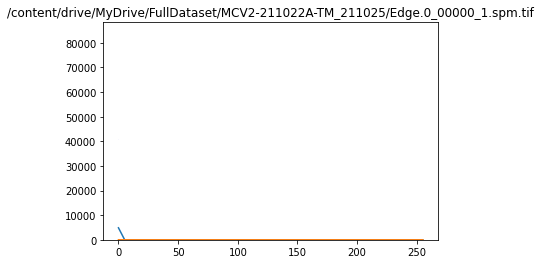

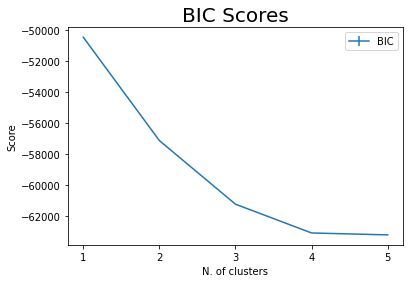

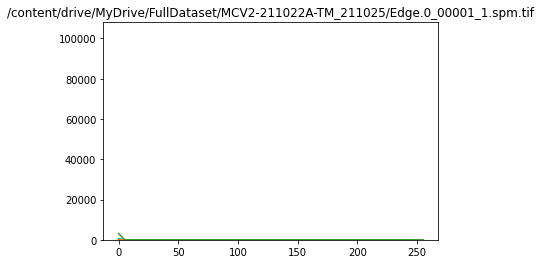

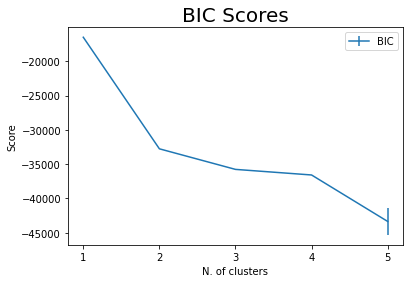

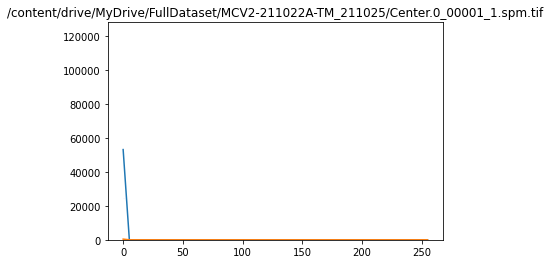

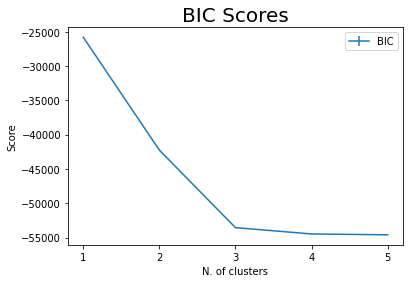

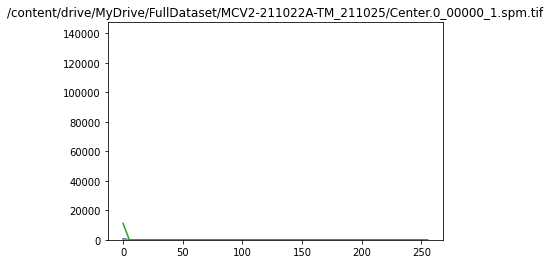

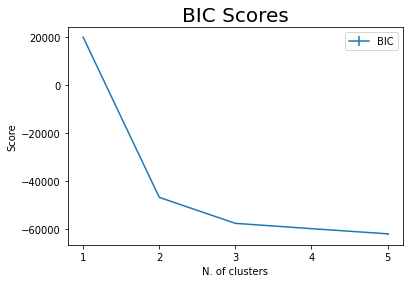

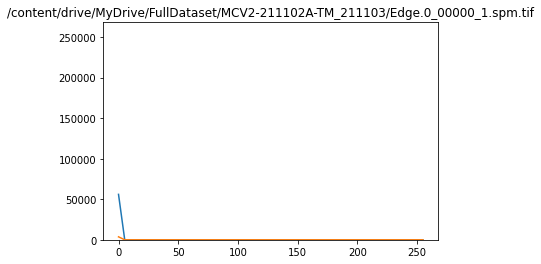

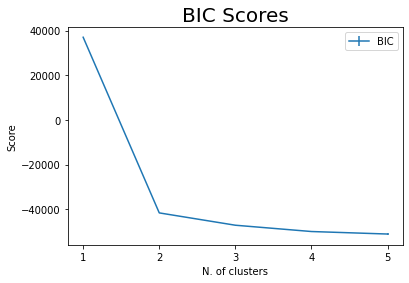

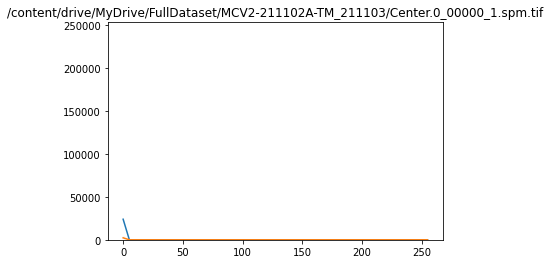

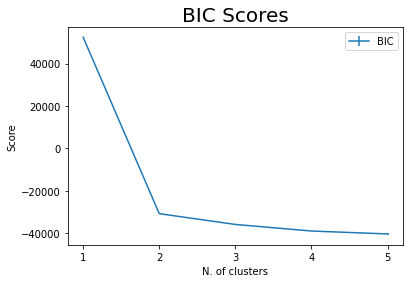

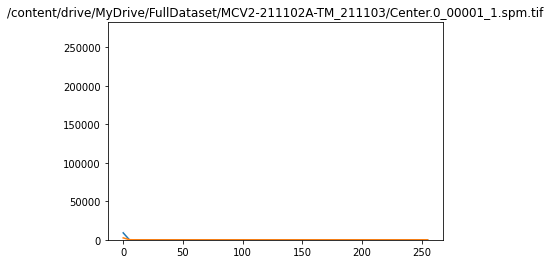

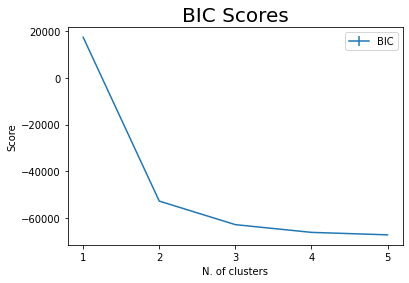

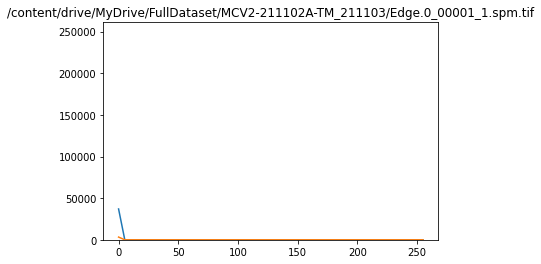

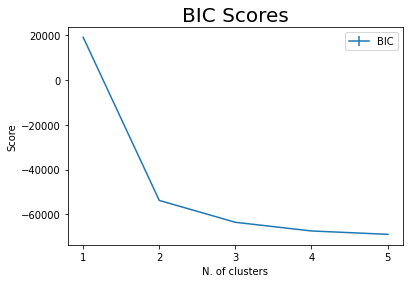

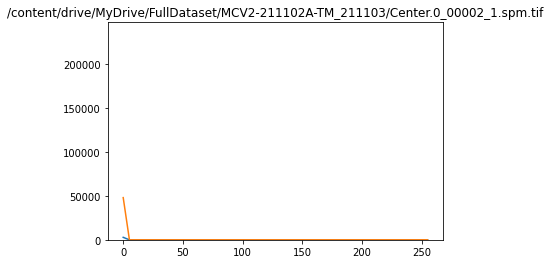

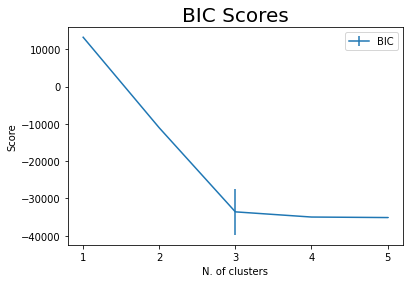

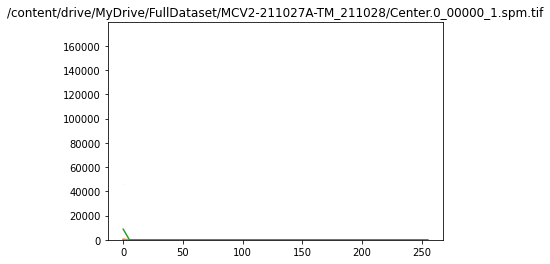

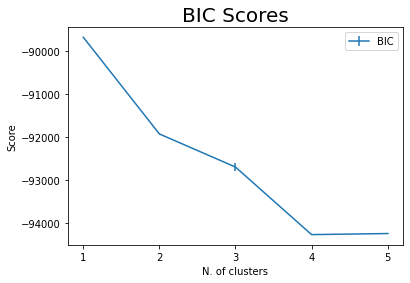

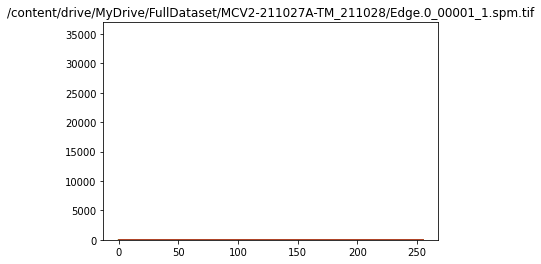

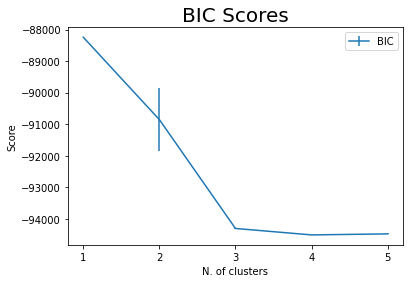

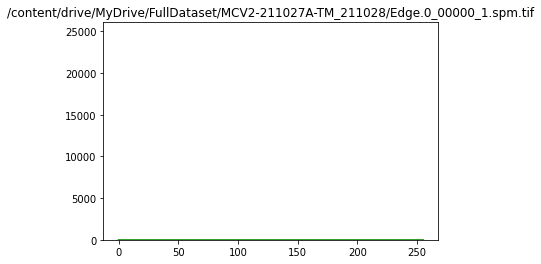

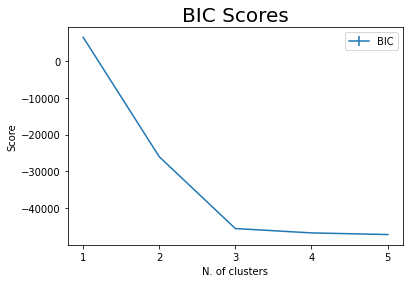

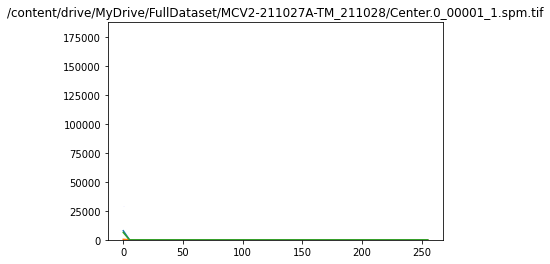

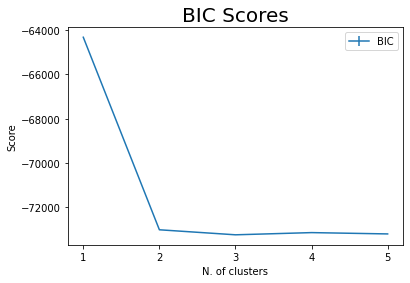

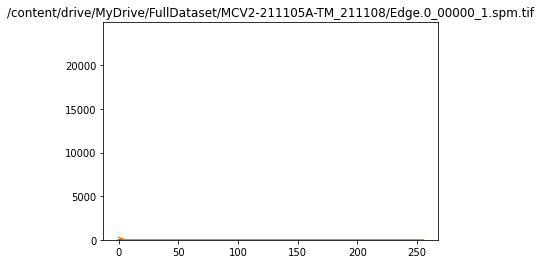

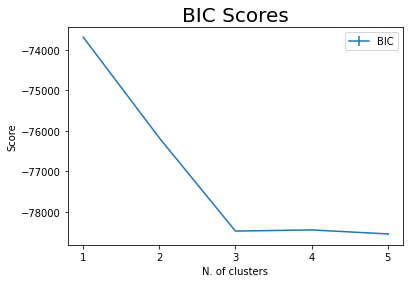

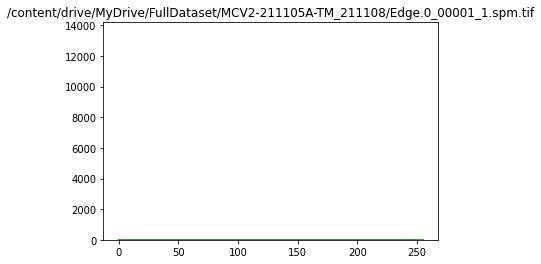

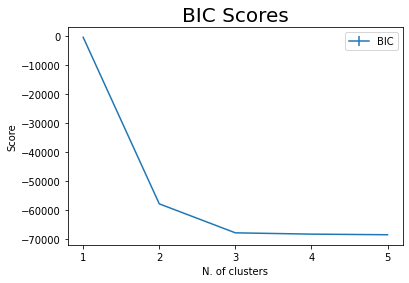

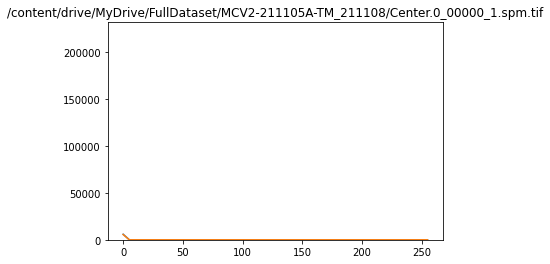

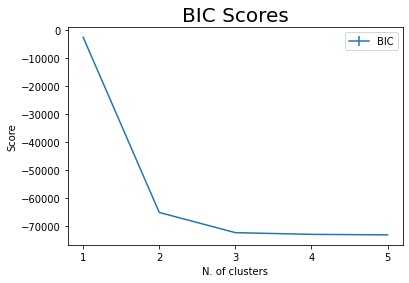

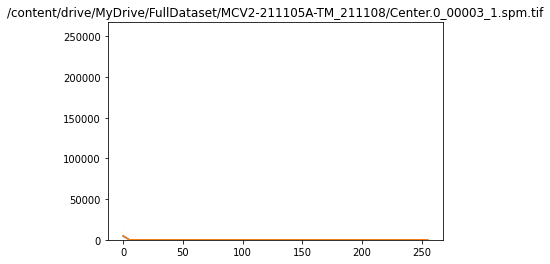

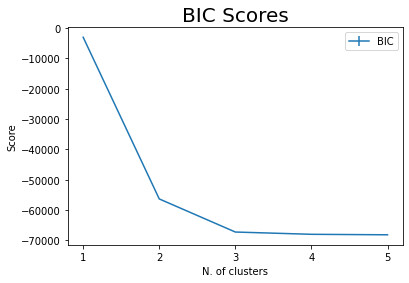

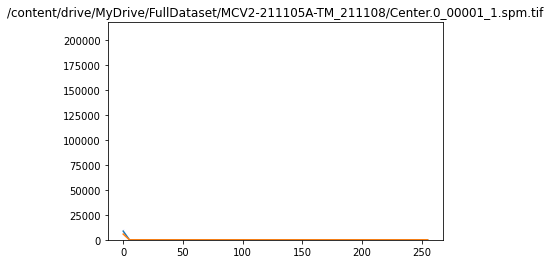

In [37]:
import torch
from glob import glob
from tqdm import notebook
import pickle
import pytesseract


IMG_SIZE = 1200
crop_rectangle = (700, 0, 1200, 1200)


all_files = glob(os.path.join(drive_prefix, '*', '*.tif'))
all_afm = []
all_cover = []
all_L = []
saved_data = []

for filename in notebook.tqdm(all_files):    
    afm = Image.open(filename).resize((IMG_SIZE, IMG_SIZE))
    print(filename)
    extractedInformation = pytesseract.image_to_data(afm.crop(crop_rectangle), config = '-c tessedit_char_whitelist=-0123456789.  --psm 12', output_type= 'data.frame')
    a = float(extractedInformation['text'][4])
    b = float(extractedInformation['text'][8])
    if b>=0:
      b= -b
    #elif b == 4.0 or b/1.0 != 0:
    #  b = float(extractedInformation['text'][12])
    afm = autocrop(afm)
    L = rgb_to_lightness(afm).flatten()
    L = np.delete(L,np.argwhere(L>=254))
    L = np.delete(L,np.argwhere(L<=1))
    L = (a-b)/L
    all_L.append(L)
    all_afm.append(afm)   
    xc, yh = smooth_histogram(L)  
    L_star, bics, n_components, gm, n = applyGMM(L, filename)
    x, cover, all_c = get_coverage(L, L_star)
    all_cover.append(cover)   
    short_filename = filename.replace(drive_prefix, '').strip('/')  # remove the prefix to drive (it can change)
    this_record = {'filename': short_filename,
                   'L_star': L_star,
                   'coverage': all_c,
                   'n_components':  int(n_components),
                   'n': int(n),
                   'BIC': bics,
                   'yh': yh.tolist(),
                   'upperlimit': a,
                   'lowerlimit': b
                  }
    saved_data.append(this_record)

    
print(saved_data)
  #save to disk via json file
with open('saved_files.json', 'w') as fid:
    json.dump(saved_data, fid)

fig, ax = plt.subplots()
ax.imshow(afm)

reading MCV2-211022A-TM_211025/Edge.0_00000_1.spm.tif has L_star =[68.32093257193112] with coverage =[[0.3243120409330147]] with BIC = [216210.4225070033, 196360.23929274888, 196373.98686290934, 195040.1476662081, 194993.1004486784]
reading MCV2-211022A-TM_211025/Edge.0_00001_1.spm.tif has L_star =[68.75421585682733] with coverage =[[0.3714292726317163]] with BIC = [213471.81234065804, 202774.98335160184, 202732.15464699836, 200357.0370834695, 200332.15891141235]
reading MCV2-211022A-TM_211025/Center.0_00001_1.spm.tif has L_star =[72.16461467321736] with coverage =[[0.3051790932131524]] with BIC = [219171.90437573864, 200271.41696330698, 200327.1653220915, 198934.38463533865, 198854.06167566788]
reading MCV2-211022A-TM_211025/Center.0_00000_1.spm.tif has L_star =[55.65204847293353] with coverage =[[0.4029590422641832]] with BIC = [222773.39891000913, 202497.66099389346, 202236.35249381344, 201227.9254989656, 200816.66540037355]
reading MCV2-211102A-TM_211103/Edge.0_00000_1.spm.tif has 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


reading Sapphire_201011/1200-8h_air_.0_00000_1.spm.tif has L_star =[63.60384105362565] with coverage =[[0.49476910304138344]] with BIC = [183494.47735623474, 183315.46456879127, 182997.08194842382, 182690.01502918883, 182500.0253228273]
reading Sapphire_201011/1300-4h_air_centre_.0_00001_1.spm.tif has L_star =[33.65952584071] with coverage =[[0.7533833525828095]] with BIC = [205154.86524180815, 201569.9404319879, 201288.81452653048, 201245.43580112004, 201178.3805576226]
reading Sapphire_201011/1200-4h_air_centre_.0_00006_1.spm.tif has L_star =[64.58639718869757] with coverage =[[0.46755975833990016]] with BIC = [173185.77669554442, 173204.04593922713, 173028.57669763724, 172868.4867124769, 172583.2273274763]
reading Sapphire_201011/1000C-8h_air_centre_.0_00002_1.spm.tif has L_star =[37.244897959183675, 49.77914822127771, 59.399893819455045] with coverage =[[0.9021161336997711], [0.7278626476154345], [0.5327477976240367]] with BIC = [175752.59345672588, 174876.98724061323, 173869.63912

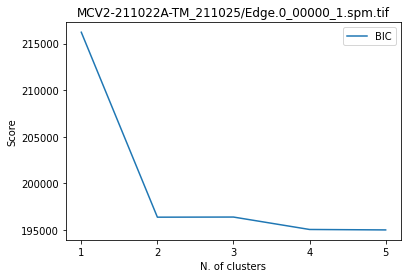

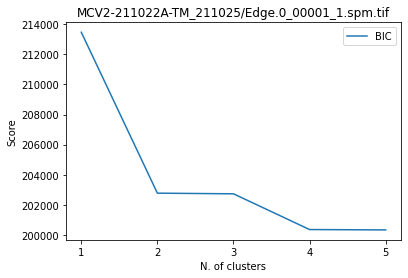

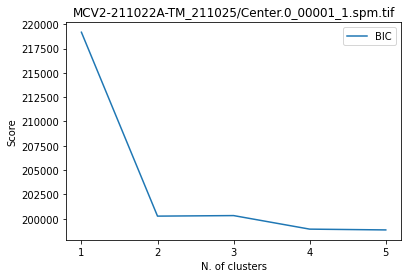

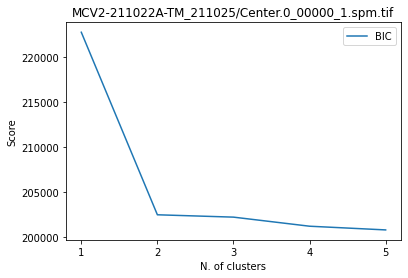

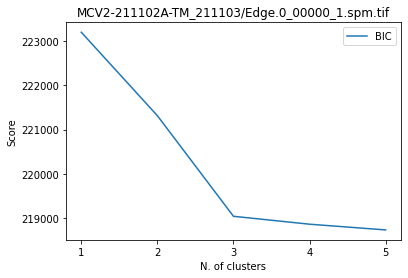

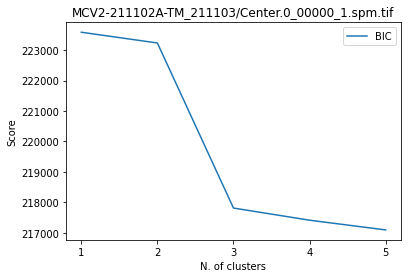

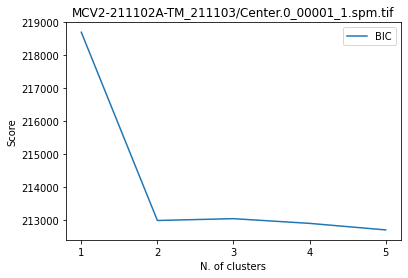

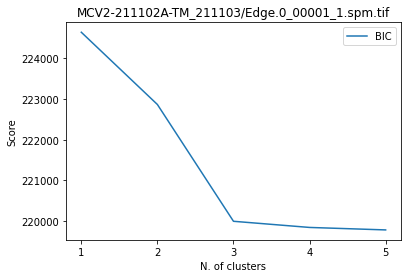

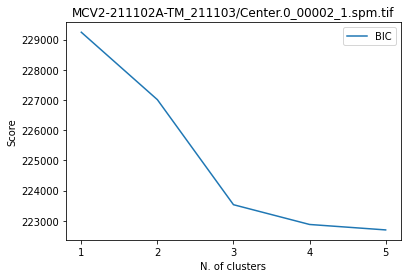

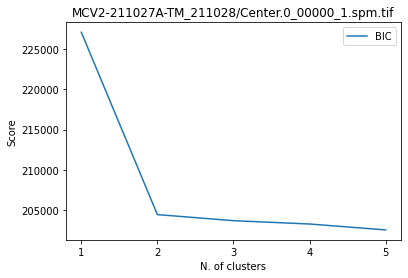

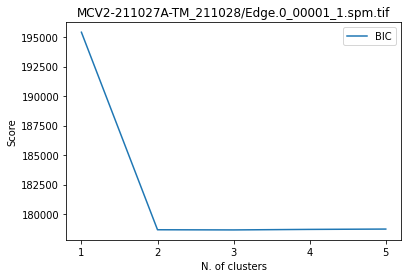

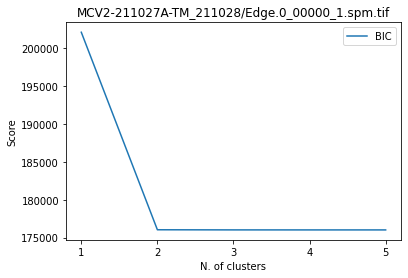

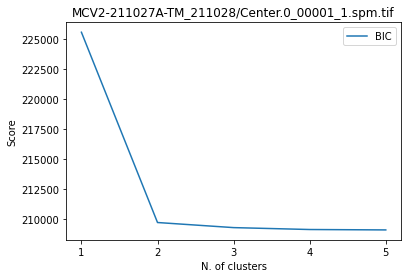

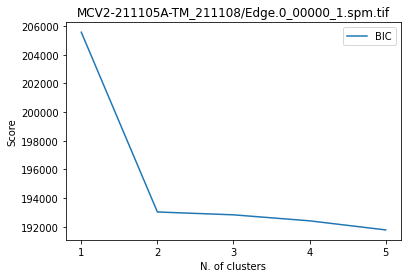

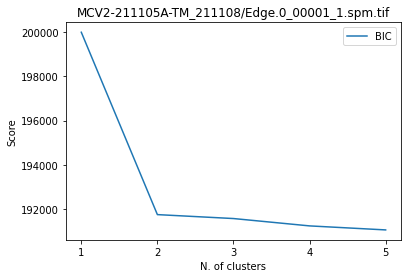

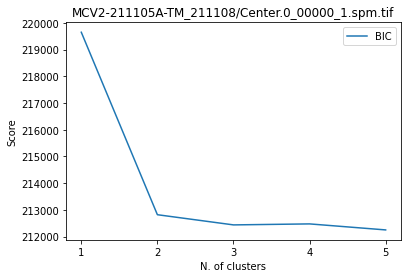

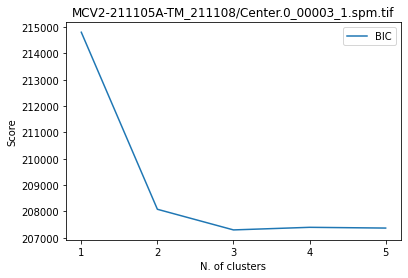

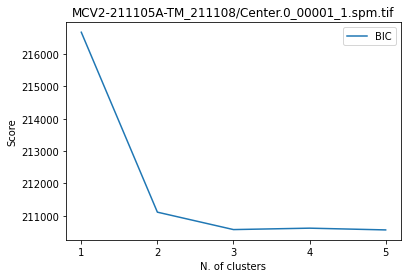

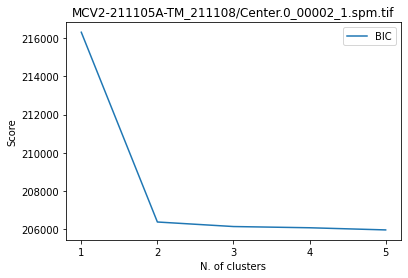

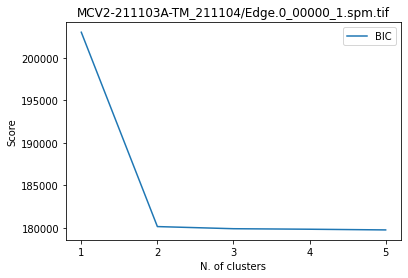

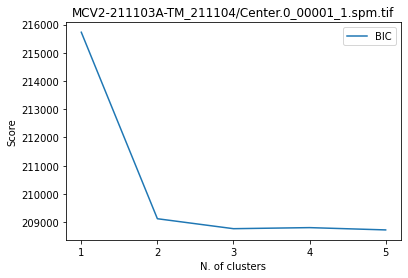

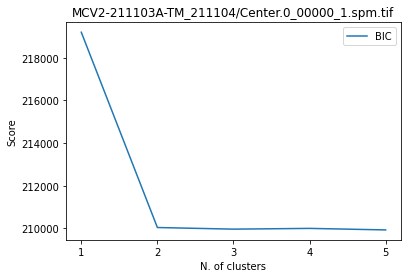

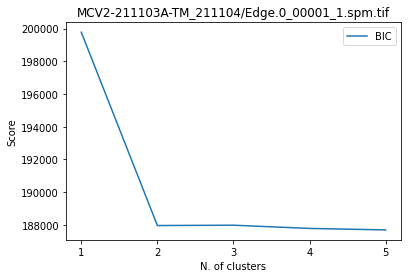

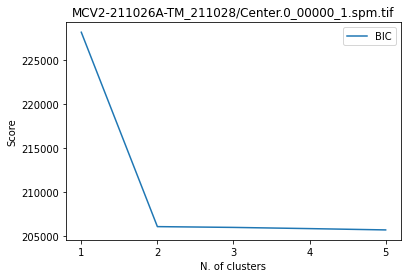

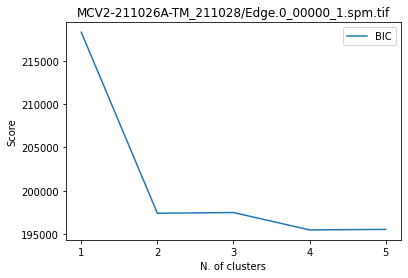

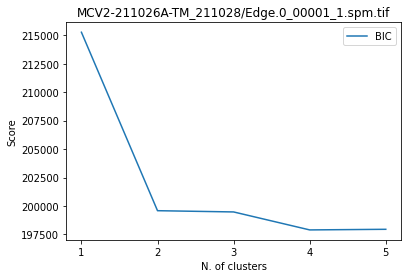

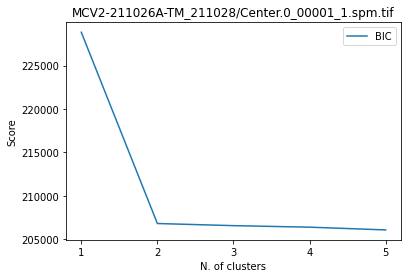

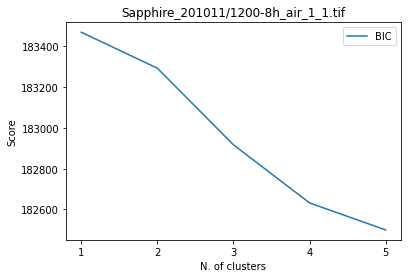

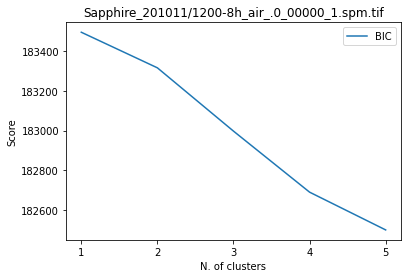

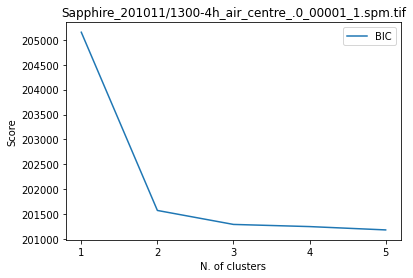

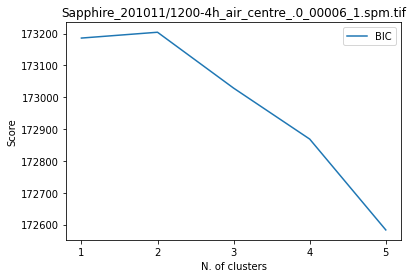

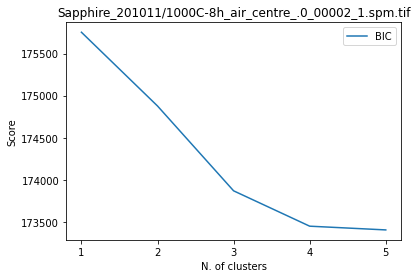

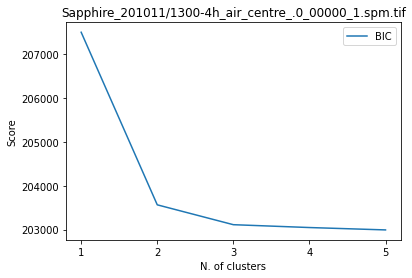

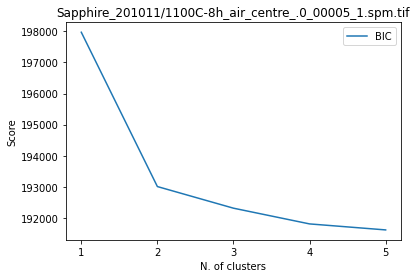

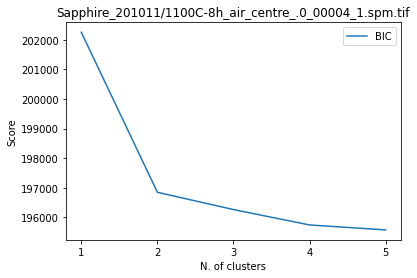

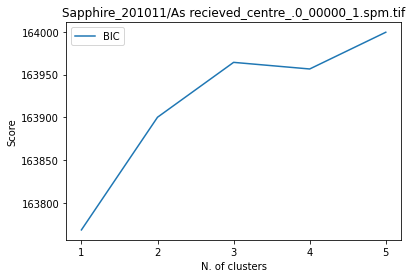

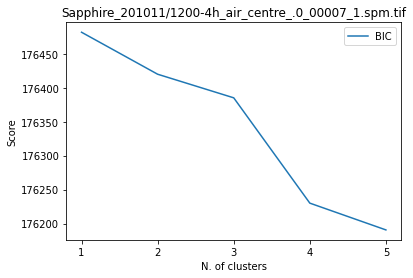

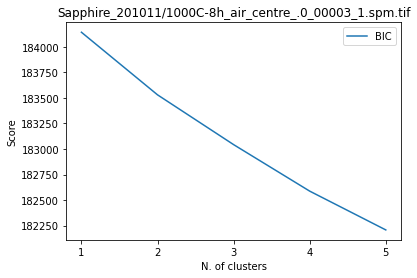

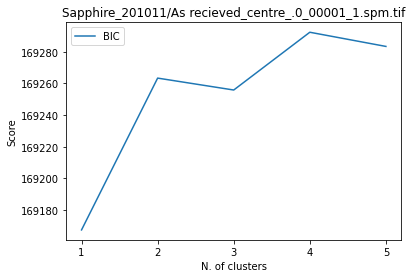

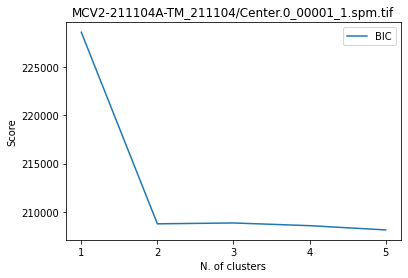

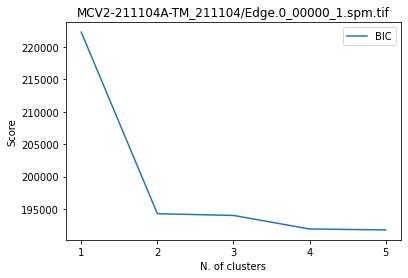

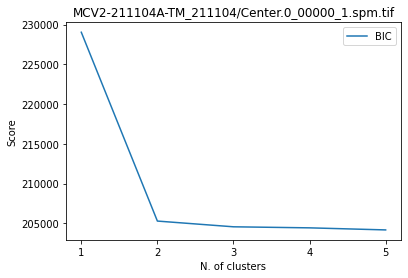

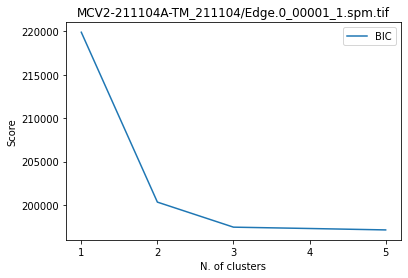

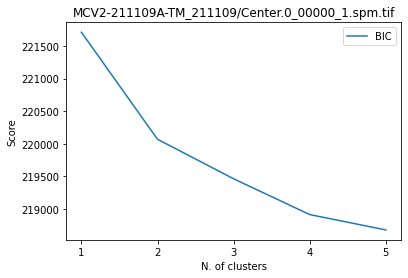

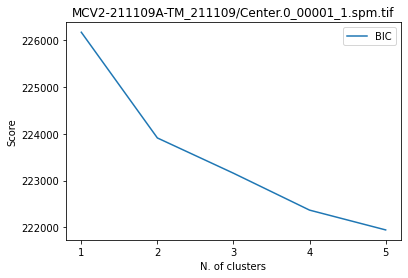

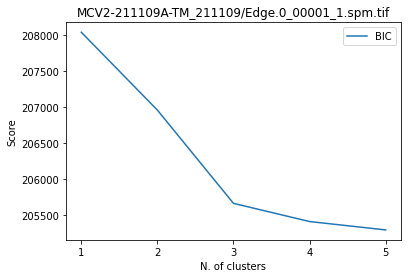

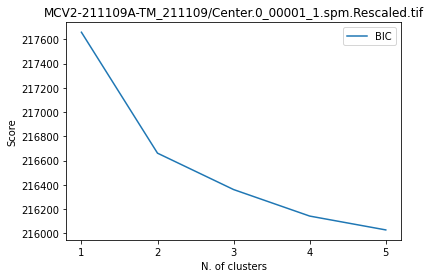

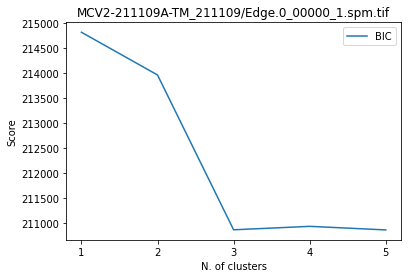

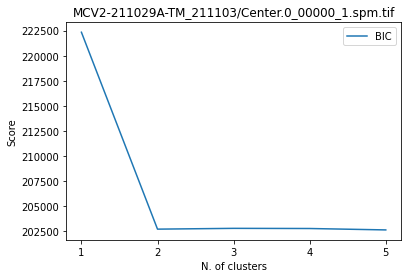

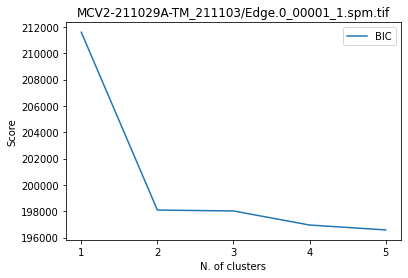

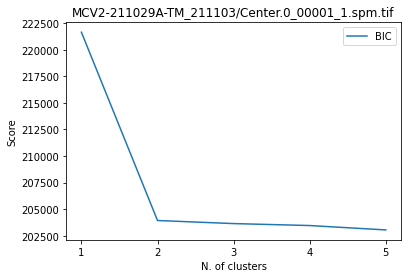

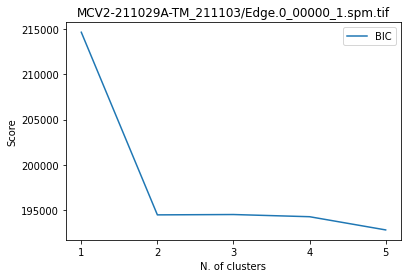

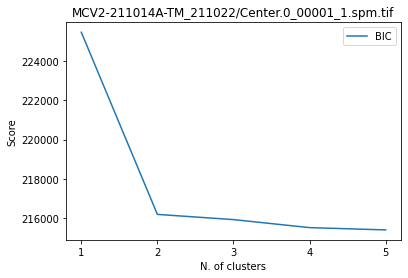

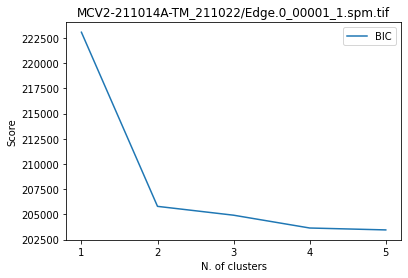

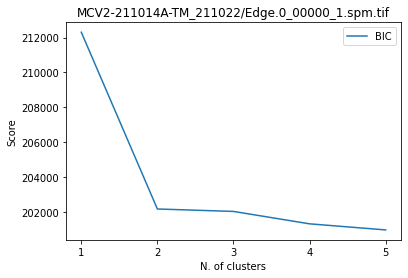

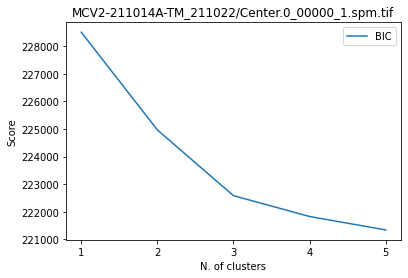

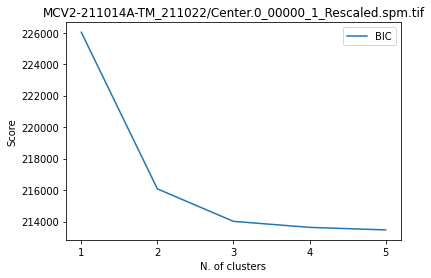

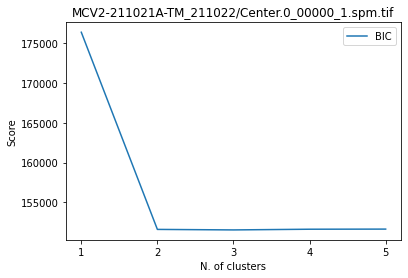

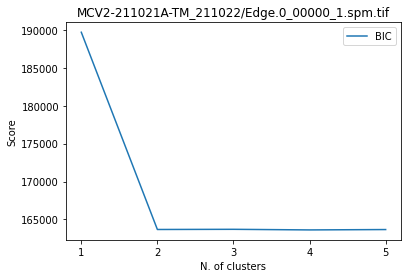

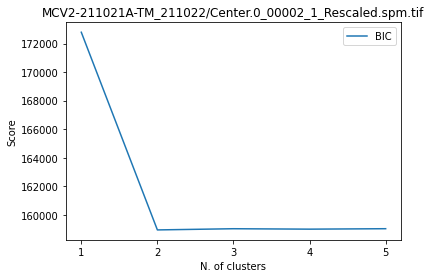

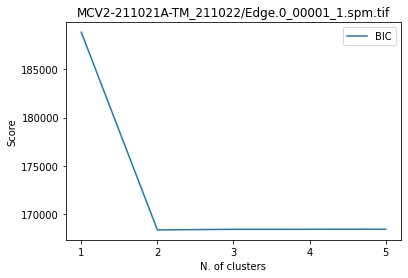

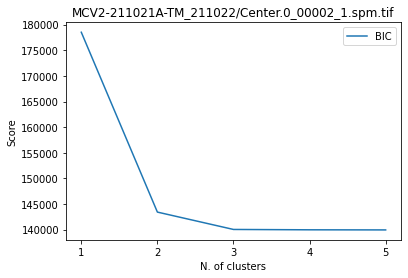

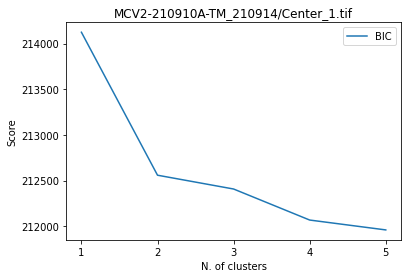

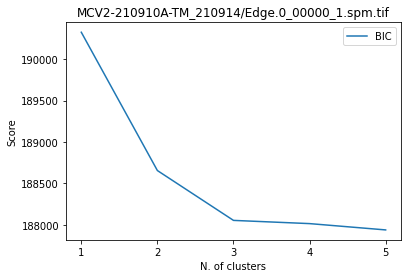

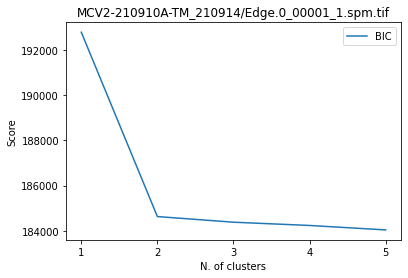

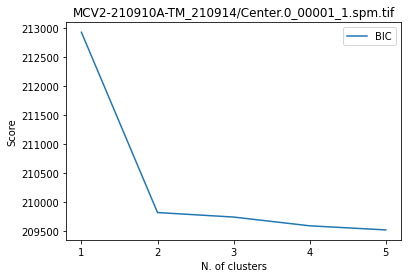

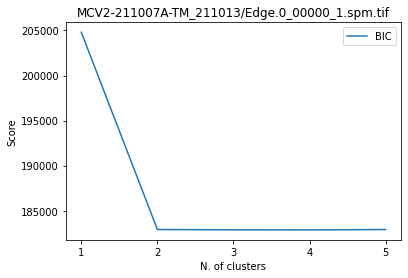

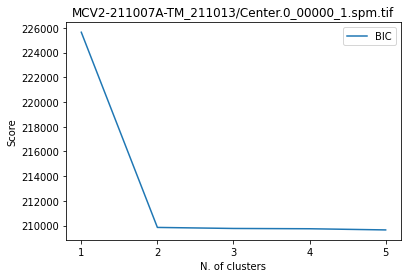

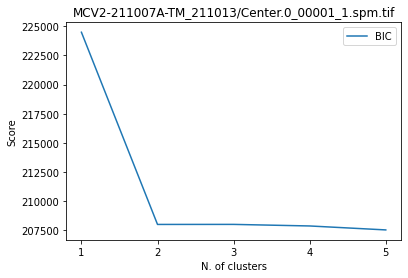

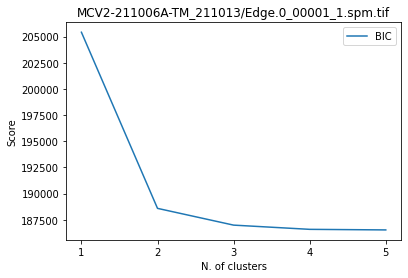

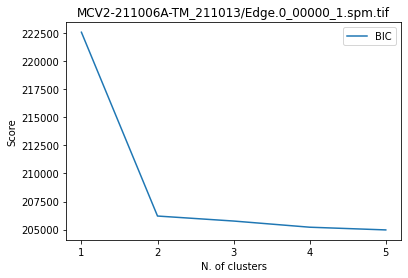

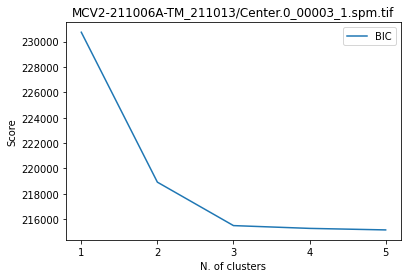

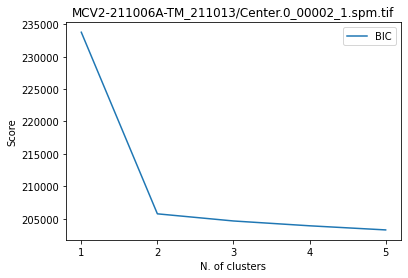

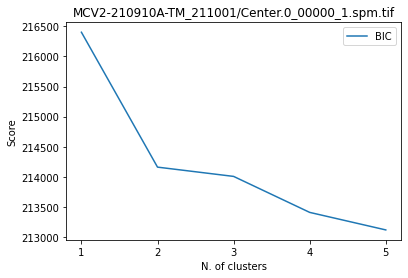

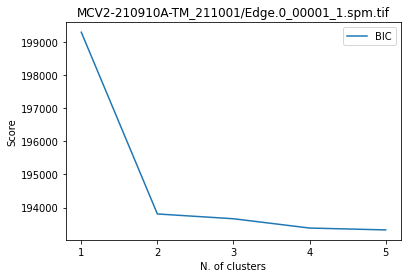

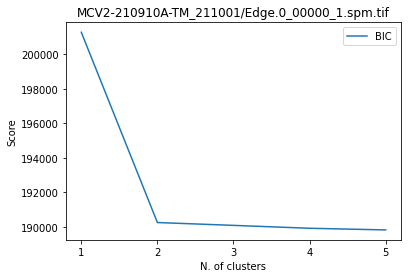

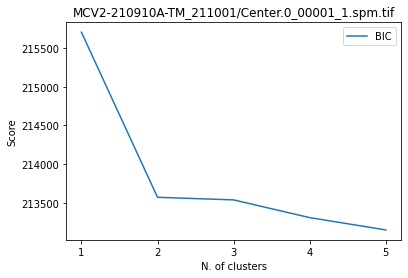

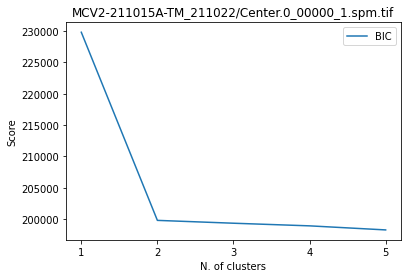

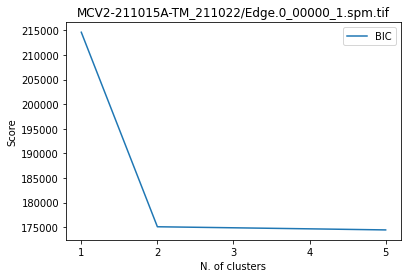

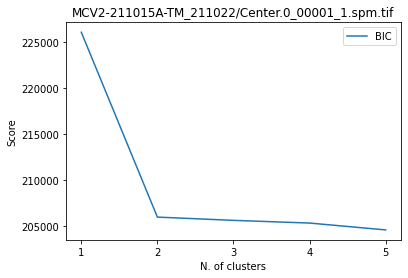

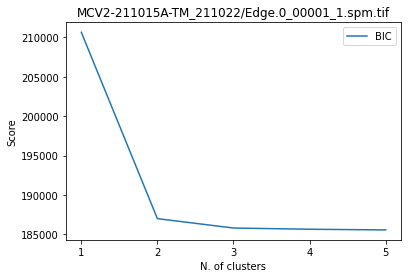

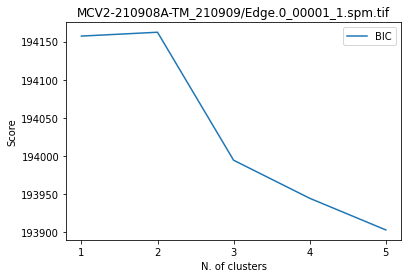

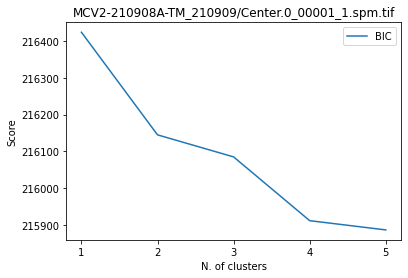

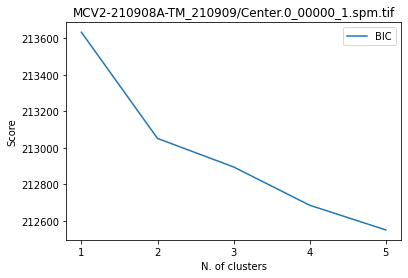

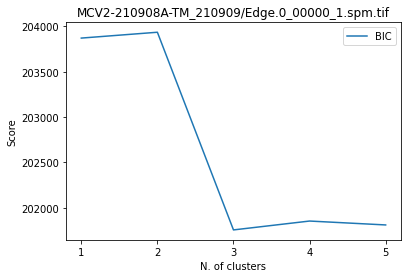

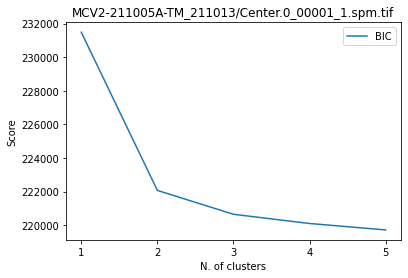

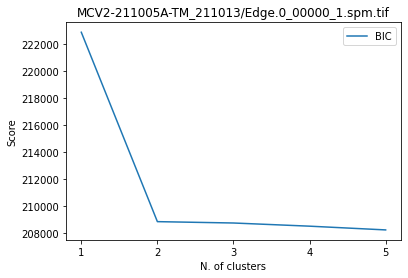

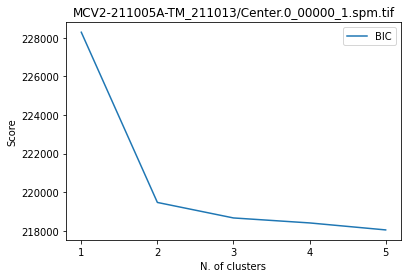

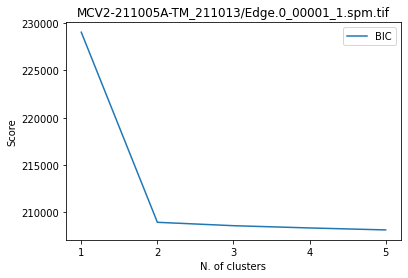

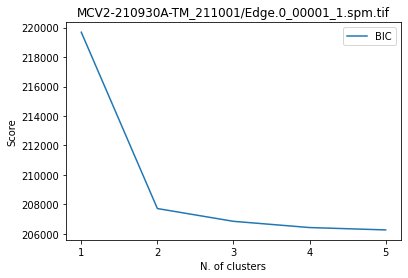

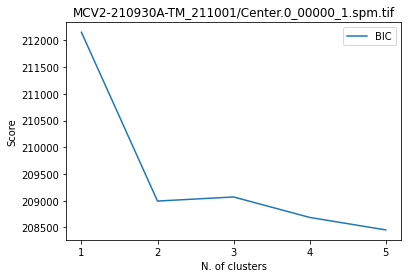

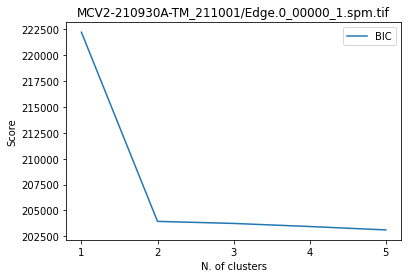

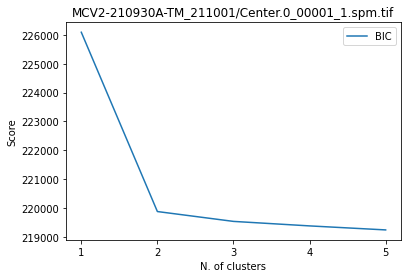

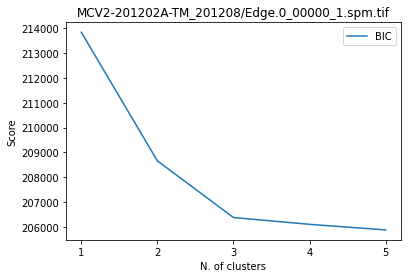

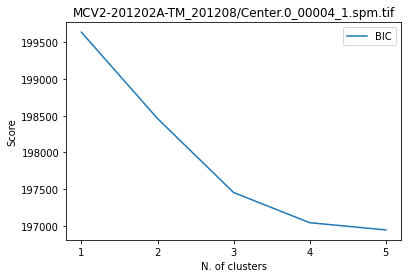

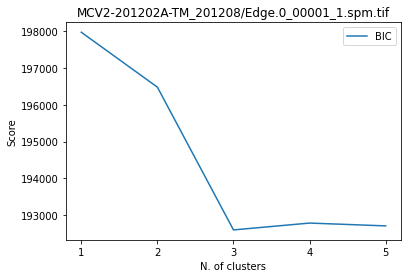

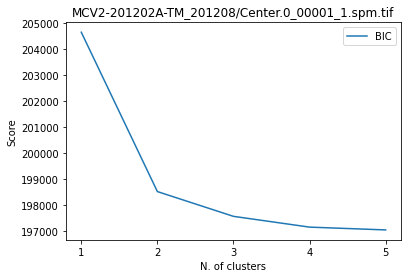

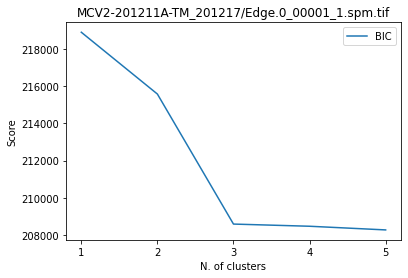

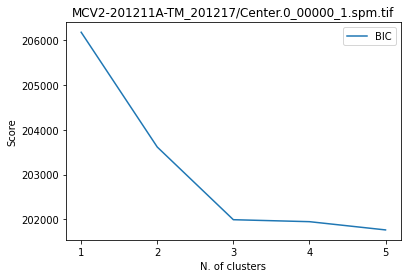

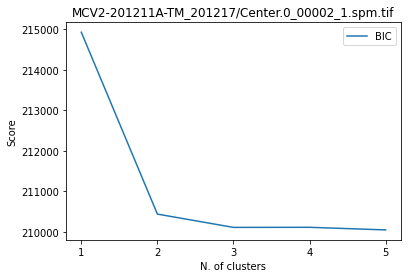

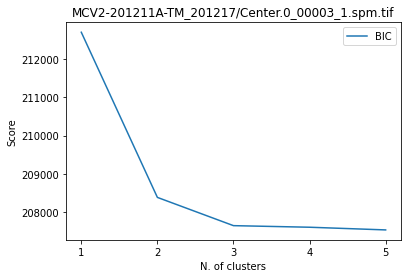

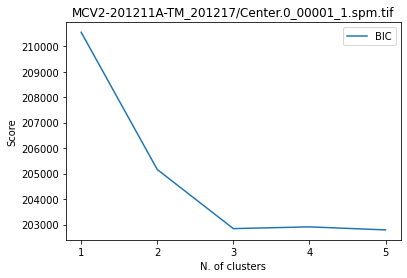

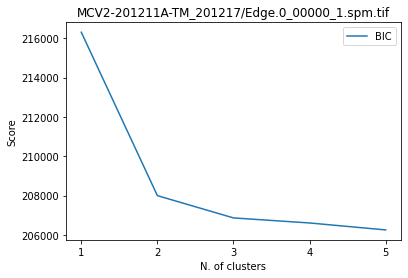

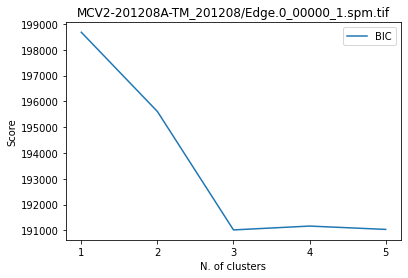

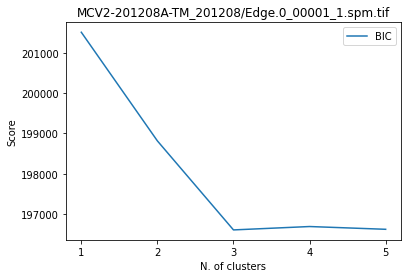

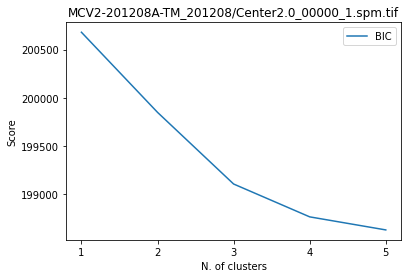

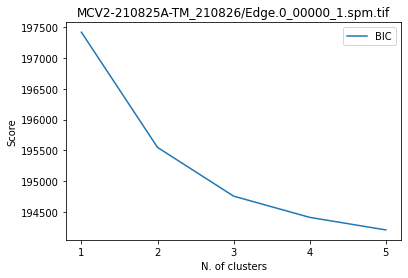

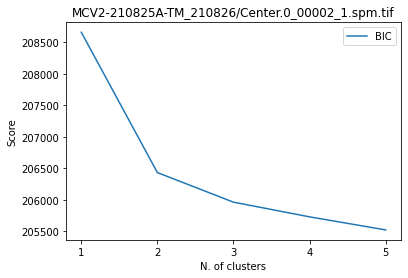

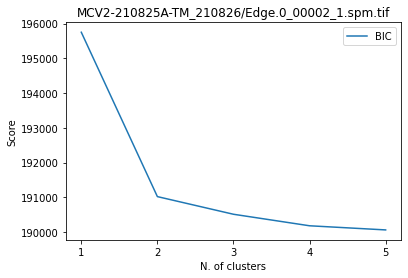

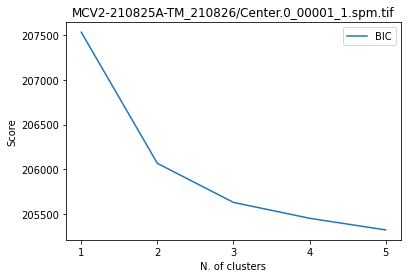

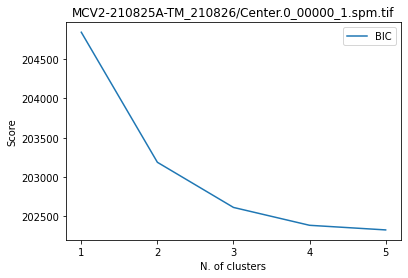

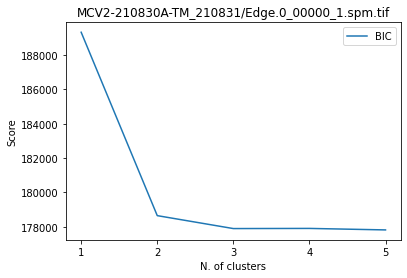

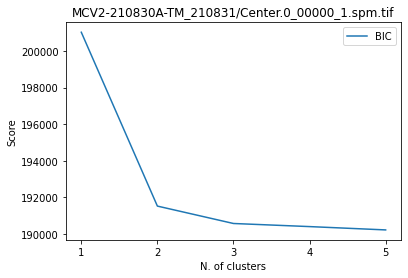

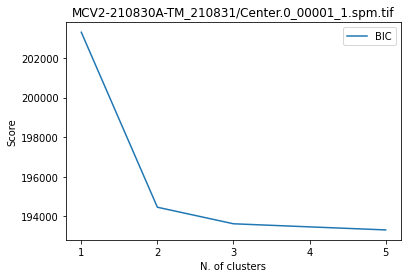

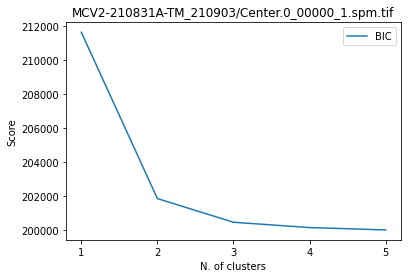

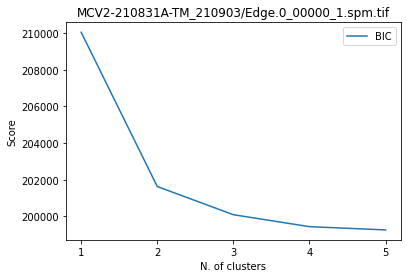

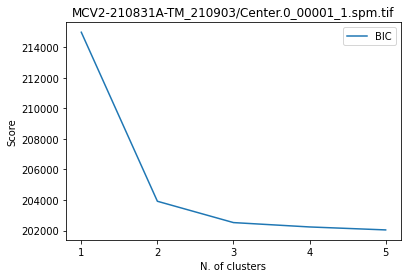

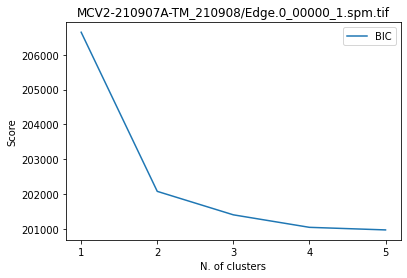

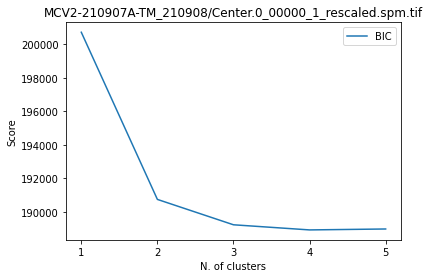

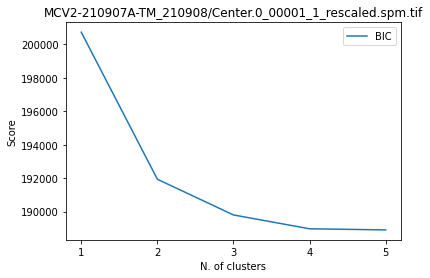

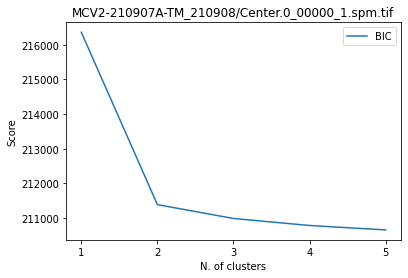

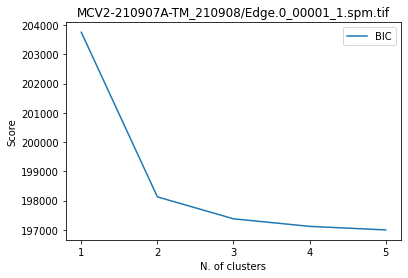

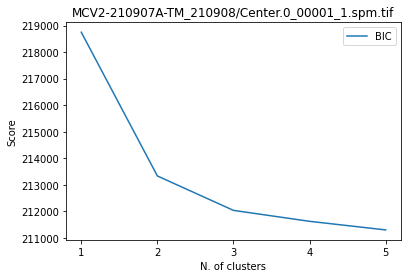

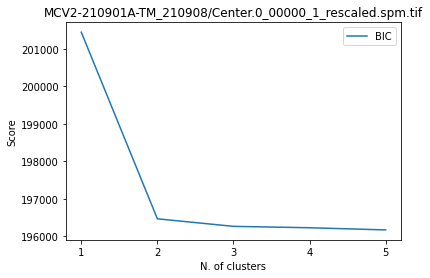

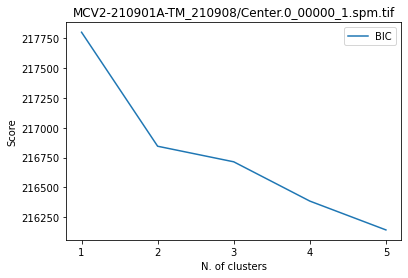

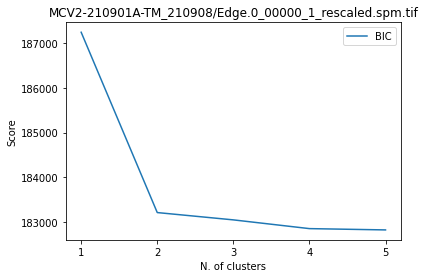

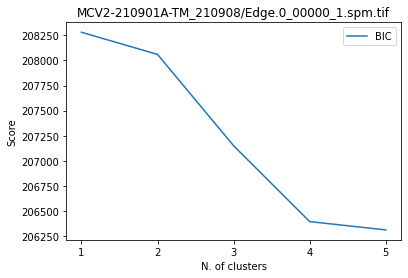

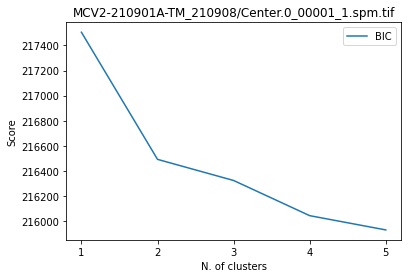

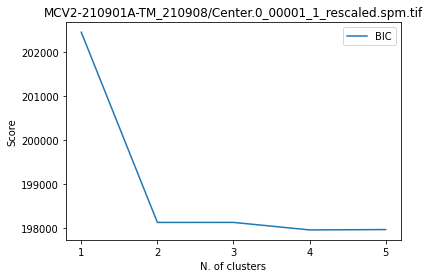

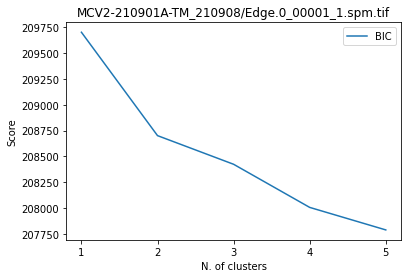

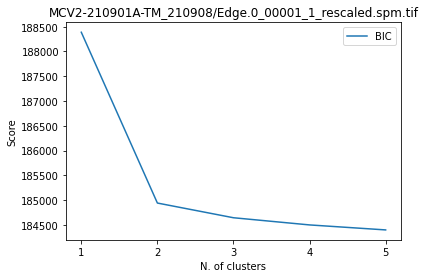

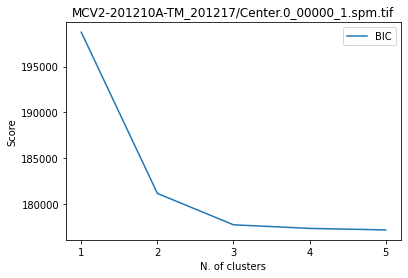

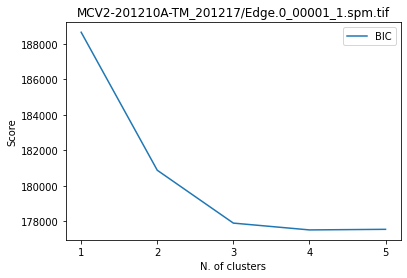

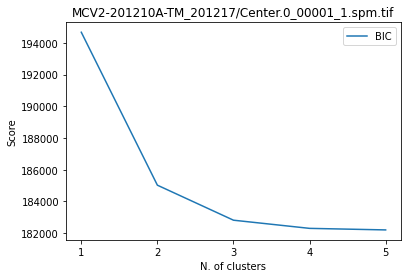

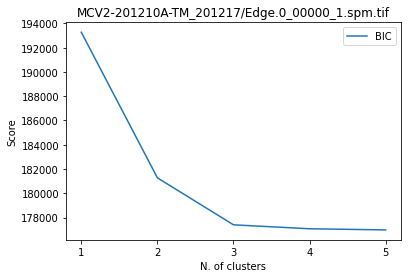

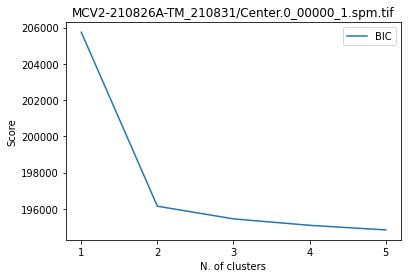

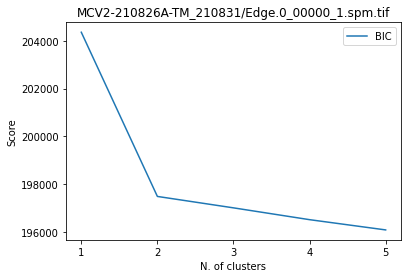

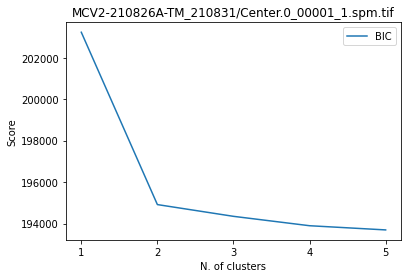

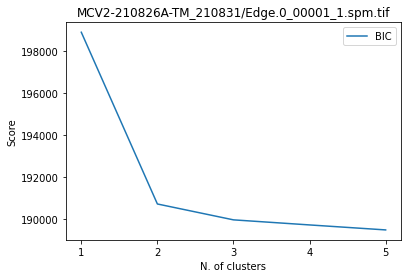

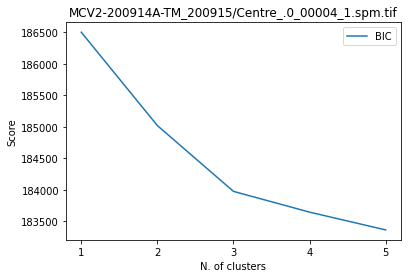

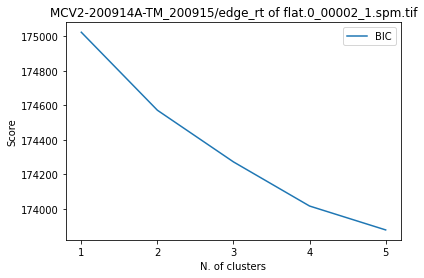

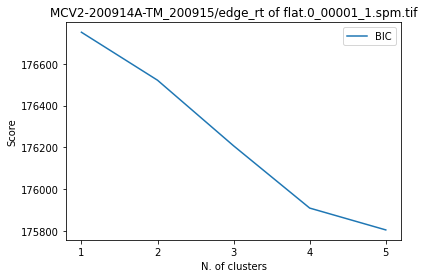

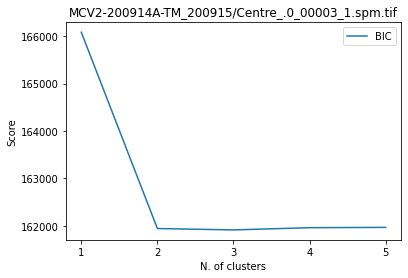

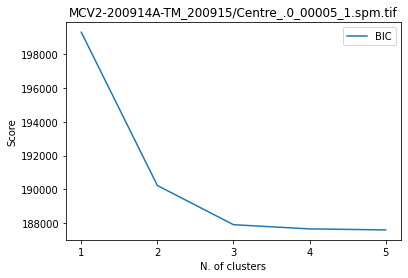

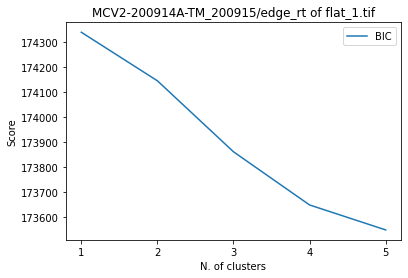

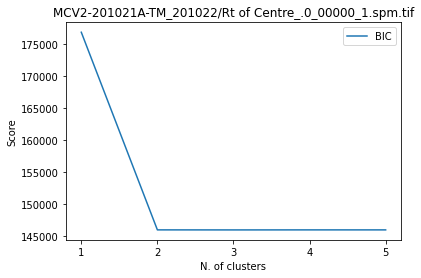

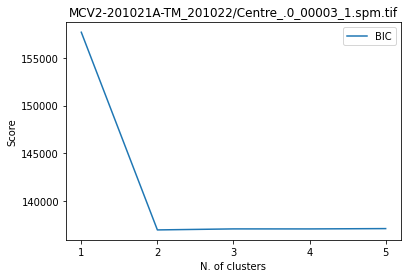

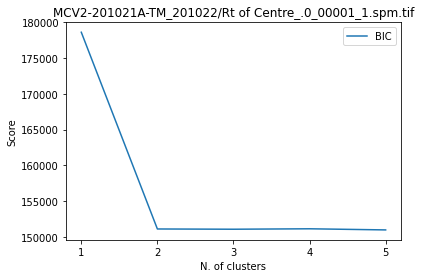

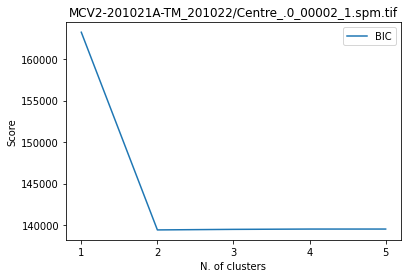

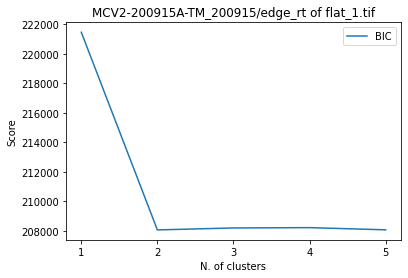

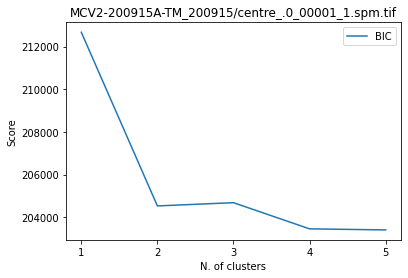

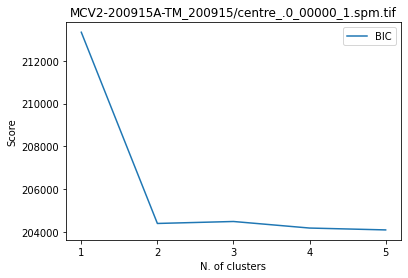

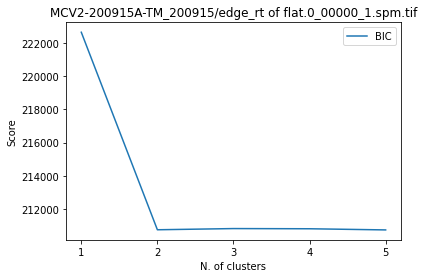

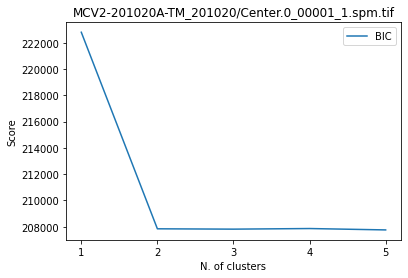

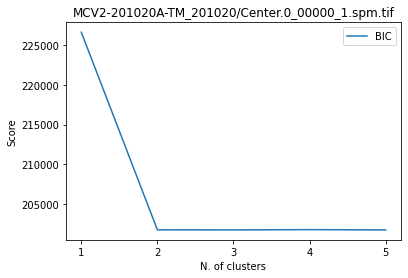

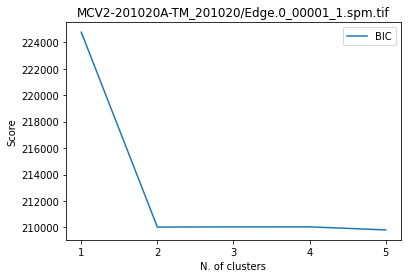

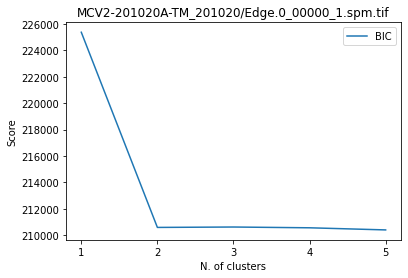

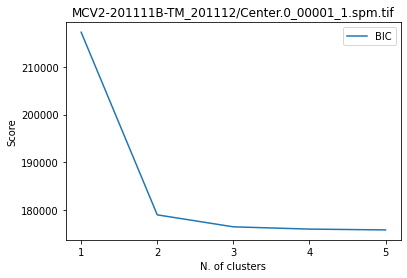

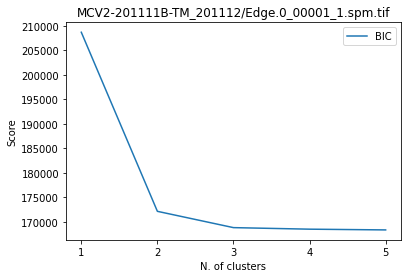

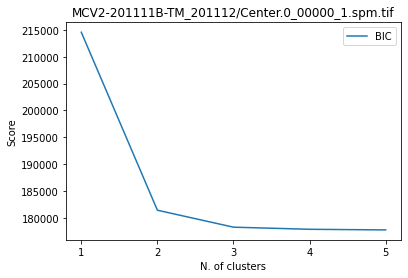

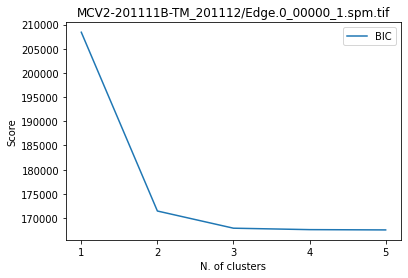

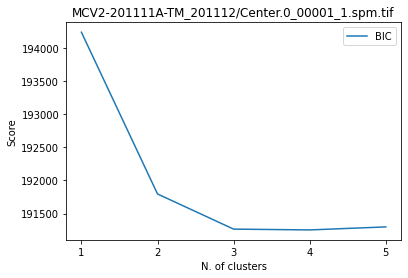

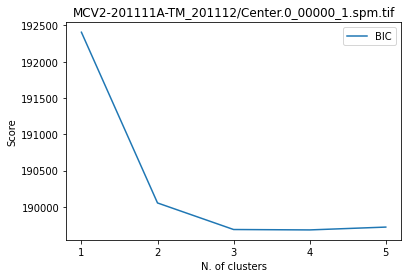

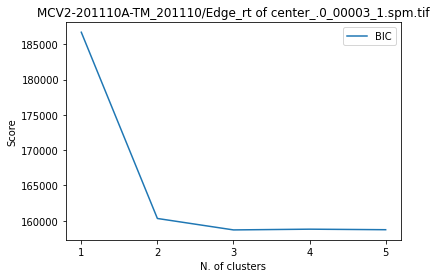

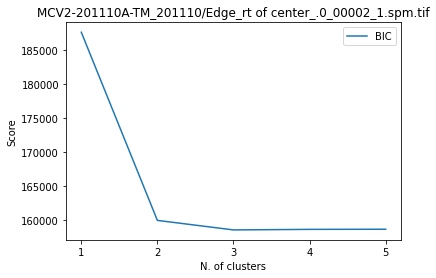

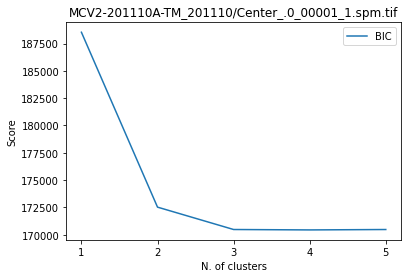

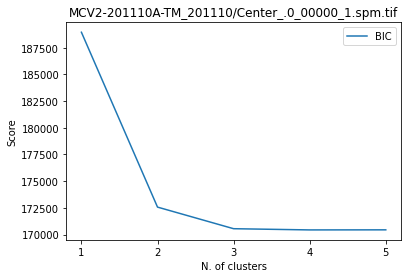

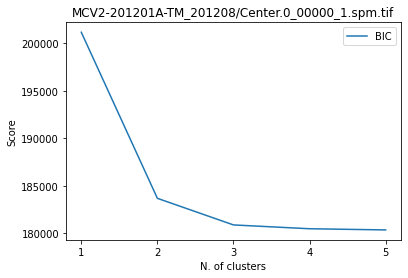

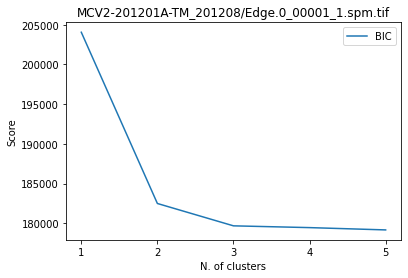

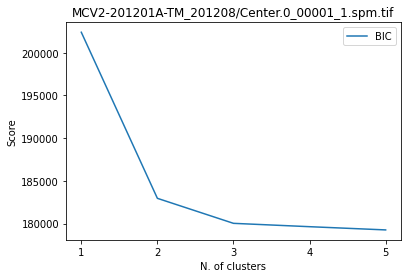

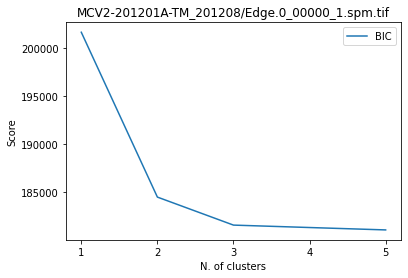

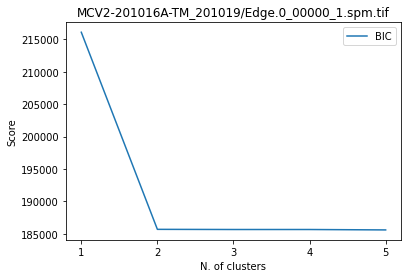

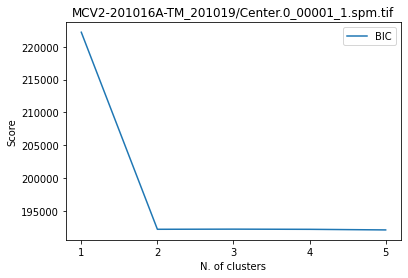

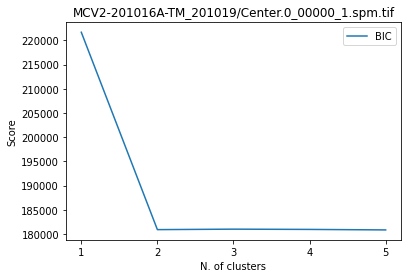

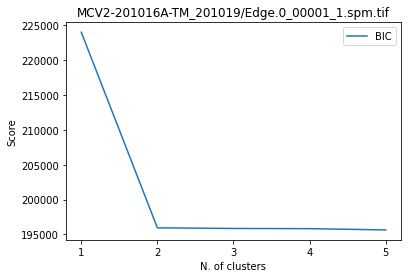

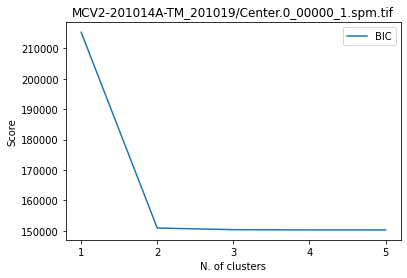

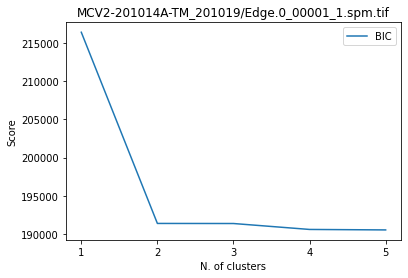

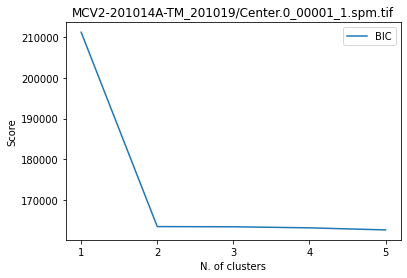

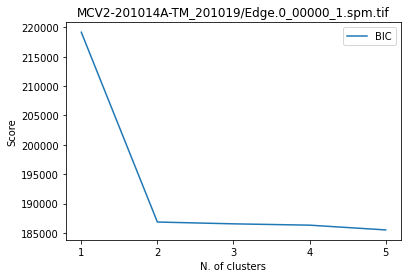

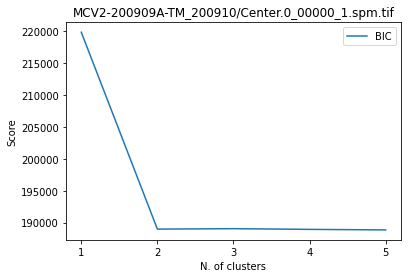

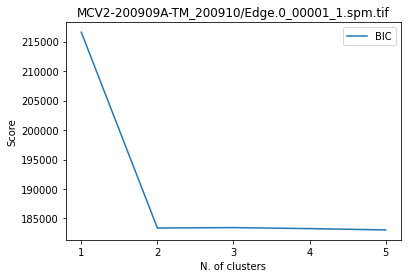

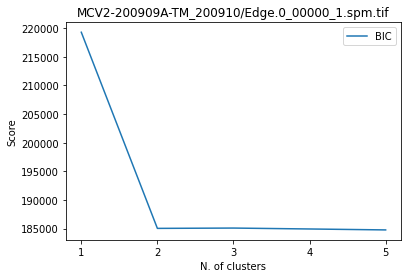

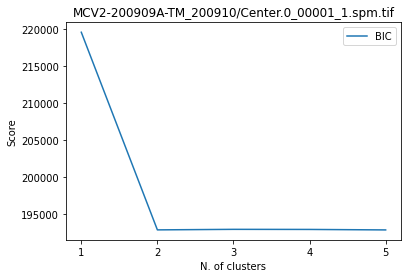

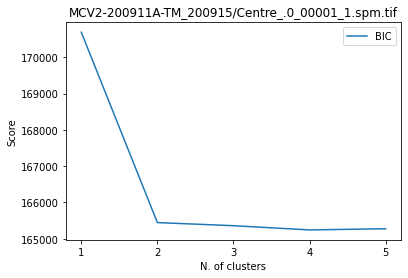

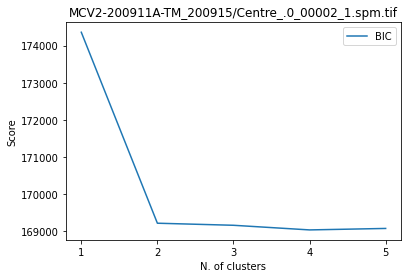

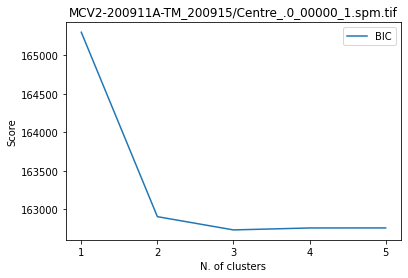

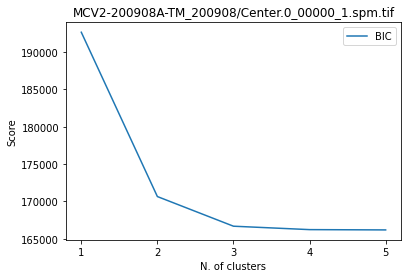

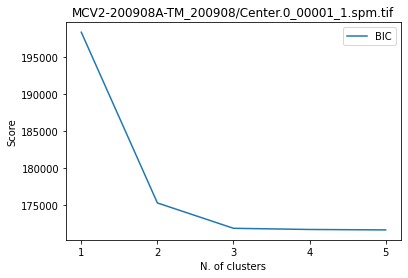

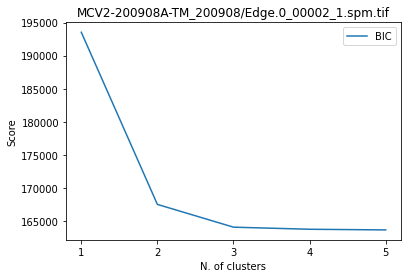

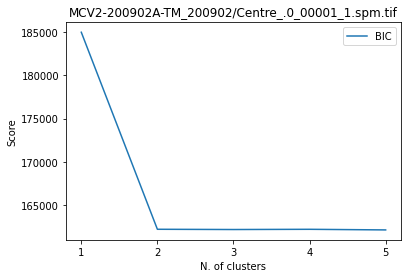

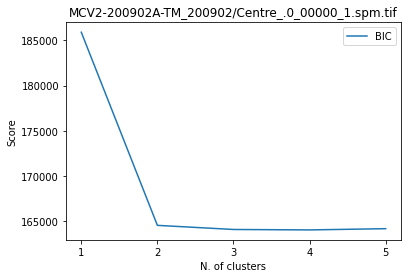

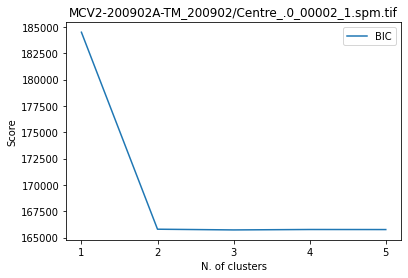

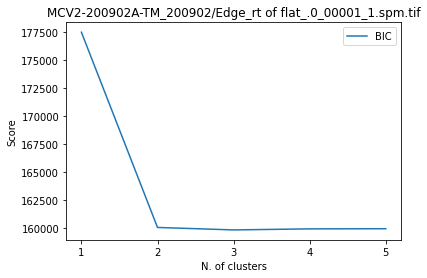

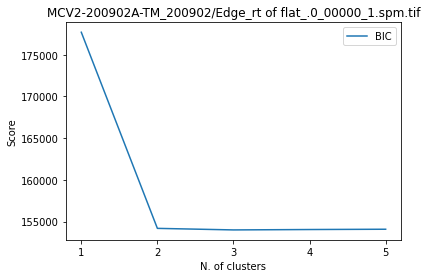

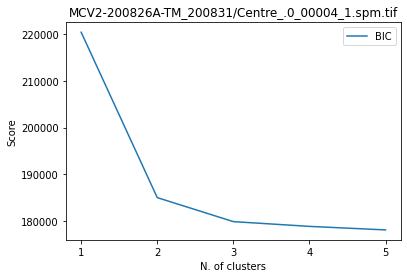

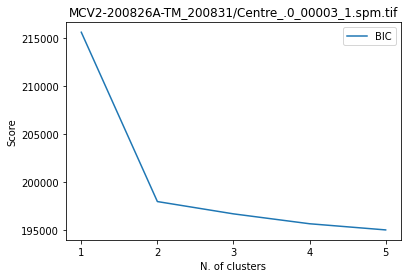

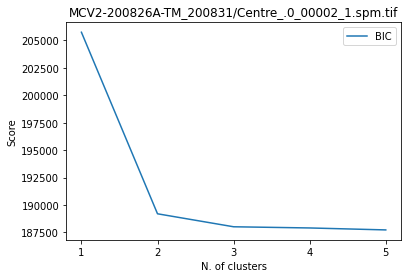

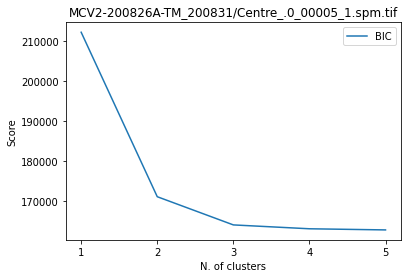

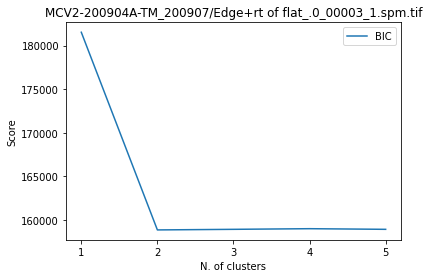

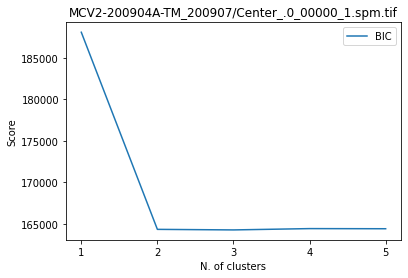

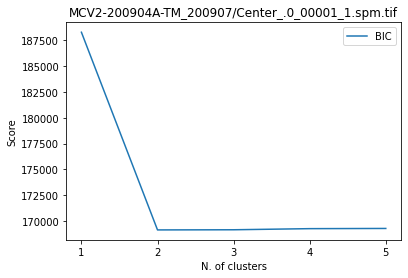

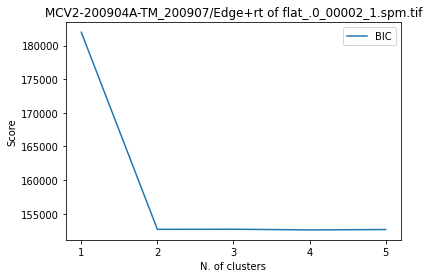

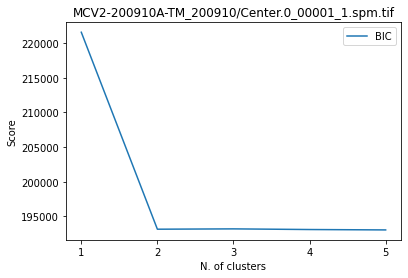

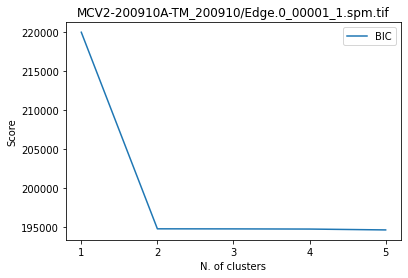

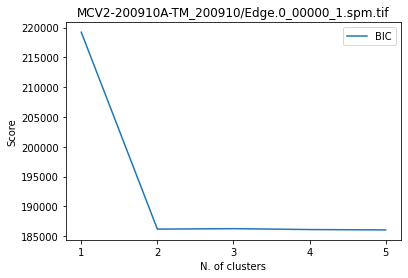

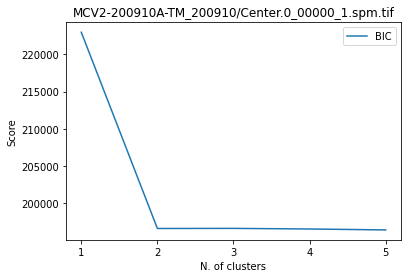

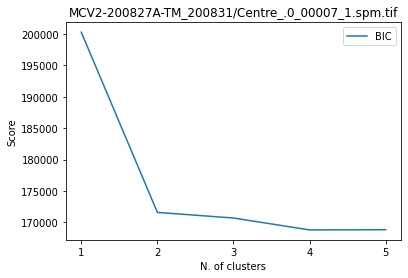

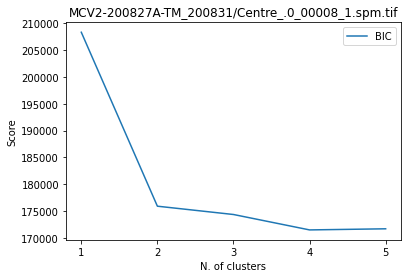

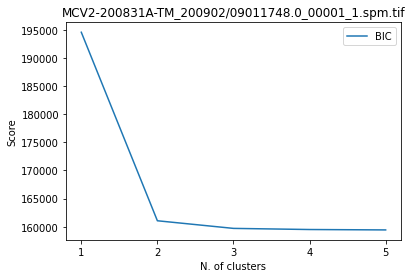

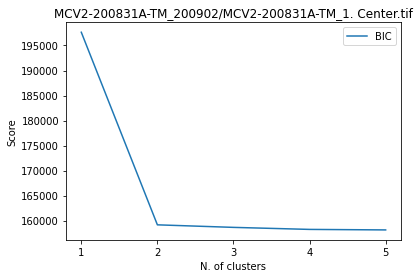

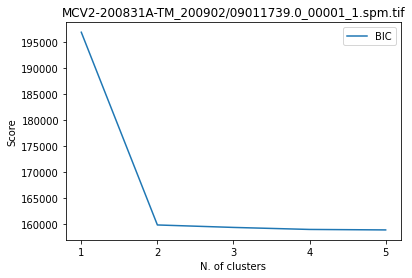

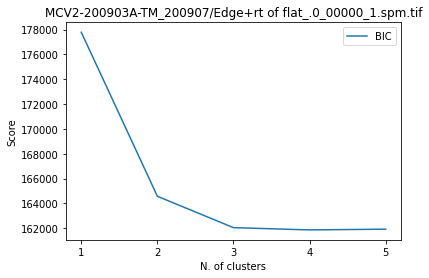

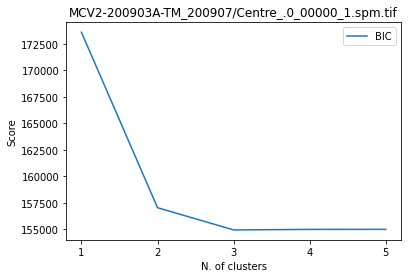

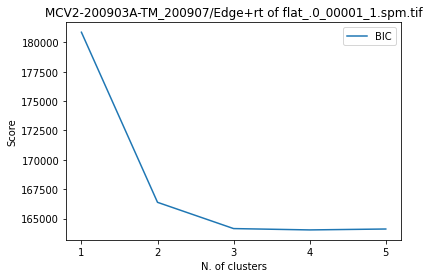

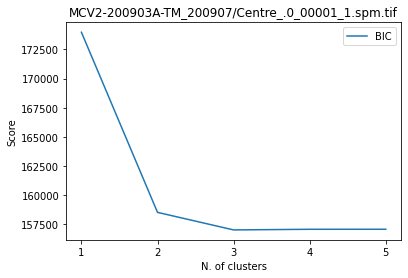

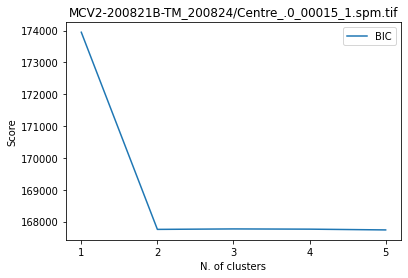

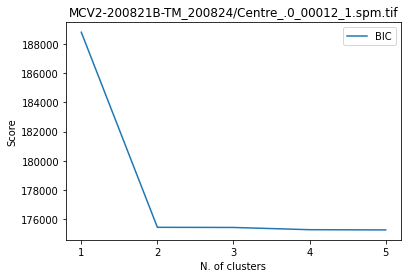

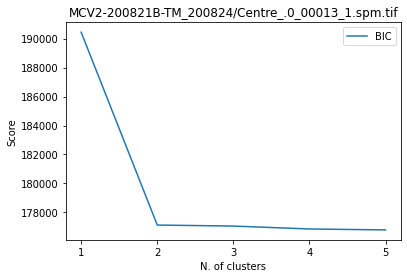

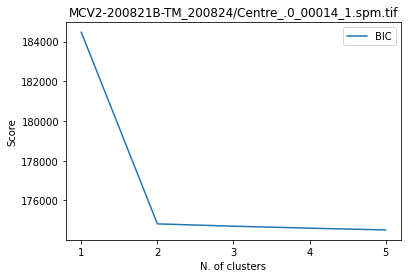

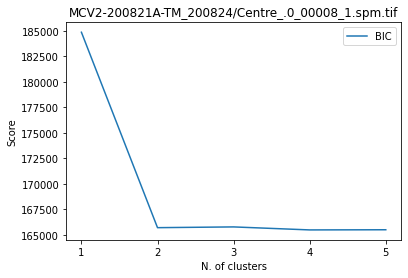

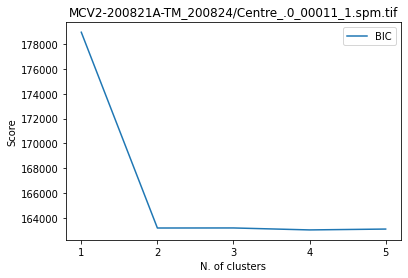

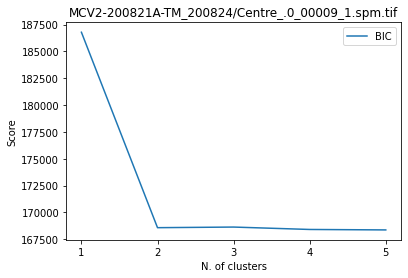

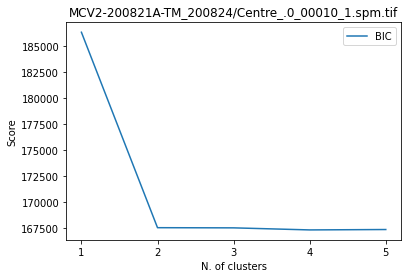

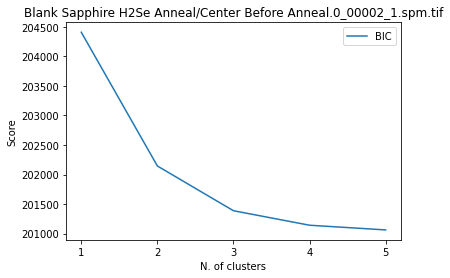

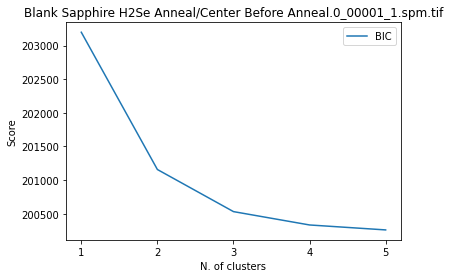

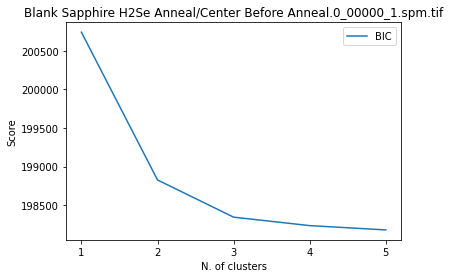

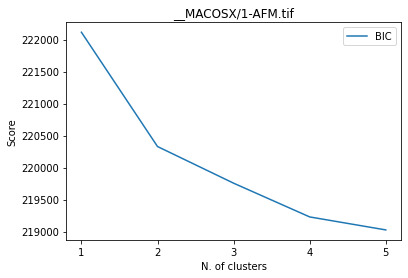

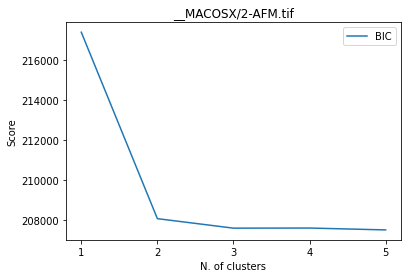

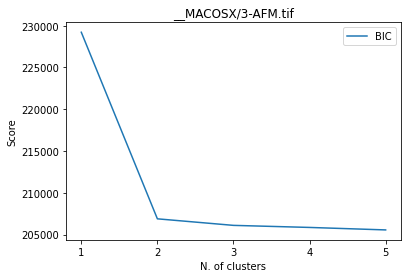

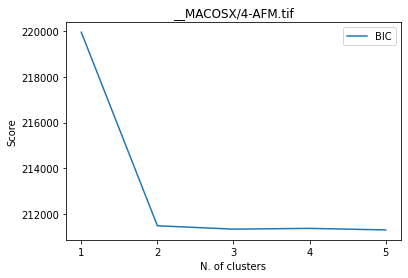

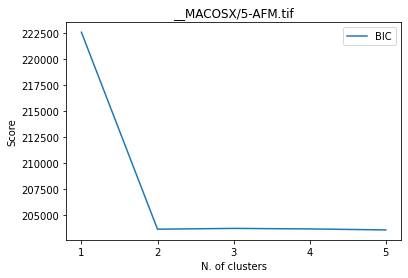

In [ ]:
import json

with open('saved_files.json', 'rb') as fid:
  data = json.load(fid)

for record in data:
    short_filename = record['filename']
    L_star = record['L_star']
    Coverage = record['coverage']
    bics = record['BIC']
    print(f'reading {short_filename} has L_star ={L_star} with coverage ={Coverage} with BIC = {bics}')
    fig, ax = plt.subplots()
    plt.errorbar(np.arange(1, 6), bics, label='BIC')
    plt.title(short_filename)
    plt.xticks(np.arange(1, 6))
    plt.xlabel("N. of clusters")
    plt.ylabel("Score")
    plt.legend()



In [ ]:
afm_dict = {}
for i, filename in enumerate(all_files):
  afm_dict[filename] = data[i]

with open('afm_saved_data.pkl', 'wb') as fid:
  pickle.dump(afm_dict, fid)

In [ ]:
with open(os.path.join('/content', 'afm_saved_data.pkl'), 'rb') as fid:
    afm_dict = pickle.load(fid)

In [ ]:
all_data = list(afm_dict.keys())
all_d = np.array([afm_dict[it] for it in all_data])
print(all_d)

[{'filename': 'MCV2-211022A-TM_211025/Edge.0_00000_1.spm.tif', 'L_star': [68.32093257193112], 'coverage': [[0.3243120409330147]], 'n_components': 2, 'n': 2, 'BIC': [216210.4225070033, 196360.23929274888, 196373.98686290934, 195040.1476662081, 194993.1004486784], 'yh': [8.585955318927971e-05, 9.910829504936606e-05, 0.000126872470251139, 0.00017266715481411654, 0.00024105112005382164, 0.00033879254301708814, 0.00047473313996709973, 0.0006592585018185982, 0.0009049075046273993, 0.0012253338376153262, 0.0016350201648031527, 0.002148148189046992, 0.00277708302524561, 0.0035311779617682696, 0.004414960994126795, 0.0054263755318508565, 0.006556151309740214, 0.007786546965064443, 0.009091955693831638, 0.010439782130045698, 0.011792263909959261, 0.013109302447827188, 0.014351080402962402, 0.015481695865760547, 0.016471779592914404, 0.01730026565424766, 0.017956089749771982, 0.018437970918161364, 0.018753634752827635, 0.018918082678558535, 0.01895126876354436, 0.018875926067271346, 0.01871484480

In [ ]:
import torchvision.models as models

model = models.efficientnet_b0(pretrained=True)
model.training = False

IMG_SIZE = 224

  0%|          | 0/231 [00:00<?, ?it/s]

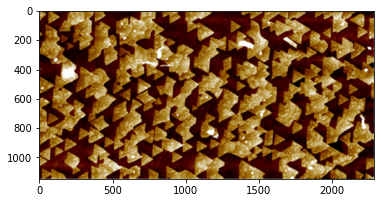

In [ ]:
import torch
from glob import glob
from tqdm import notebook

all_files = glob(os.path.join(drive_prefix, '*', '*.tif'))
all_afm = []
all_z = []
for filename in notebook.tqdm(all_files):
    afm = autocrop(Image.open(filename)).resize((IMG_SIZE, IMG_SIZE))
    all_afm.append(afm)
    #
    x = torch.tensor(np.array(afm).transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0)
    z = model(x)  # run through the pretrained model
    all_z.append(z.detach().numpy()[0])

fig, ax = plt.subplots()
ax.imshow(afm)

In [ ]:
import pickle

z_dict = {}
for i, filename in enumerate(all_files):
    z_dict[filename] = all_z[i]

with open('afm_z.pkl', 'wb') as fid:
    pickle.dump(z_dict, fid)

In [ ]:
with open(os.path.join('/content', 'afm_z.pkl'), 'rb') as fid:
    z_dict = pickle.load(fid)

In [ ]:
all_files = list(z_dict.keys())
all_z = np.array([z_dict[it] for it in all_files])
print(all_z.shape)

(231, 1000)


In [ ]:
import pandas as pd

with open('saved_files.json', 'rb') as fid:
  label_data = json.load(fid)

#print(label_data['record'])

all_filename = []
all_coverage = []
for i, record in enumerate(label_data):
    short_filename = record['filename']
    coverage = record['coverage'][0][0]
    all_filename.append(short_filename)
    all_coverage.append(coverage)


X_keys = [os.path.join(drive_prefix, filename) for filename in all_filename]
X_ids = []
for xk in X_keys:
    this = [id for id, it in enumerate(all_files) if xk in it]
    X_ids.append(this[0])

X = np.array([all_z[it] for it in X_ids])
y = all_coverage

In [ ]:
from sklearn import linear_model
from sklearn import model_selection

Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y)
model = linear_model.Lasso().fit(Xtrain, ytrain)
print(model.score(Xtrain, ytrain), model.score(Xtest, ytest))

-2.1760371282653068e-14 -0.06742336597531606


In [ ]:
co = np.vstack([X.T, y])
print(co.shape)

(1001, 231)


In [ ]:
corr = np.corrcoef(co)[-1, :-1]
print(corr.shape)

(1000,)


In [ ]:
corr[np.argsort(np.abs(corr))[::-1]][:10]

array([ 0.22785225,  0.2180179 , -0.20740399, -0.20592136, -0.20056362,
        0.19522379,  0.19108225,  0.18939038, -0.18238101, -0.1803185 ])

In [ ]:
np.argsort(np.abs(corr))[::-1][:2]

array([151, 880])

In [ ]:
yh = []

for record in label_data:
  Lightness = record['yh']
  yh.append(np.array(Lightness))

L = np.array(yh)
print(L.shape)

(231, 255)


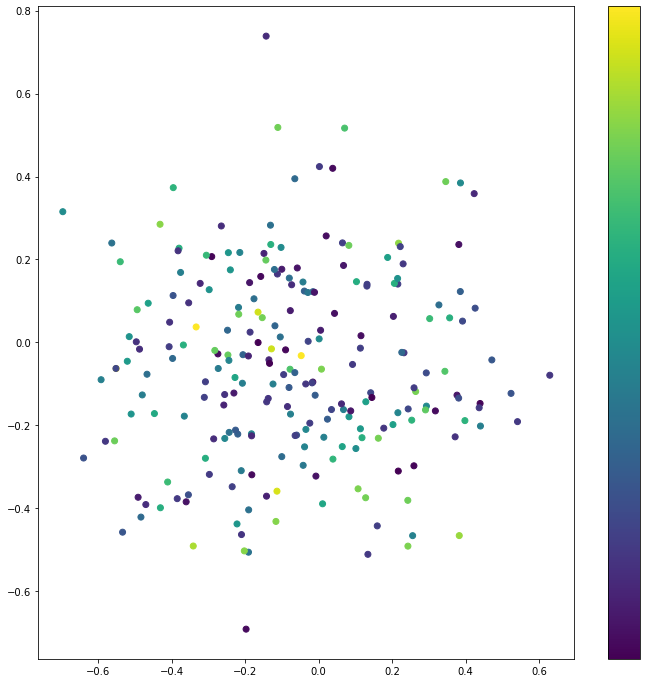

In [ ]:
from sklearn import decomposition
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.colors

color = np.array(y)

pca = decomposition.PCA(n_components=2).fit(L)
a = pca.transform(L)
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(a[:, 0], a[:, 1],  c = color)
plt.colorbar(ticks=np.arange(len(color)))

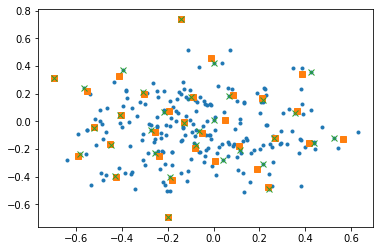

In [ ]:
from sklearn import cluster


x = a[:, 2:4]
km = cluster.KMeans(n_clusters=32).fit(x)
centers = km.cluster_centers_

c_ids = []
for i in range(km.n_clusters):
    this_id = np.argmin(np.linalg.norm(centers[i] - x, axis=1))
    c_ids.append(this_id)

fig, ax = plt.subplots()
ax.plot(a[:, 0], a[:, 1], '.')
ax.plot(*centers[:, :2].T, 's')
ax.plot(*x[c_ids].T, 'x')

In [ ]:
import torch
from glob import glob
from tqdm import notebook

IMG_SIZE =224
all_files = glob(os.path.join(drive_prefix, '*', '*.tif'))
all_afm = []
for filename in notebook.tqdm(all_files):
    afm = autocrop(Image.open(filename)).resize((IMG_SIZE, IMG_SIZE))
    all_afm.append(afm)

  0%|          | 0/231 [00:00<?, ?it/s]

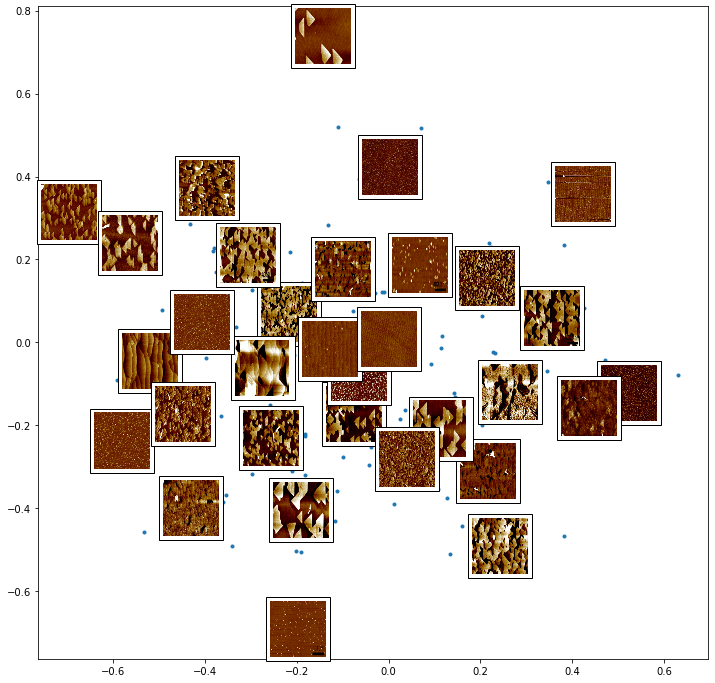

In [ ]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(x[:, 0], x[:,1], '.')
ax.plot(*centers[:, :2].T, 's')
ax.plot(*x[c_ids].T, 'x')

for i in c_ids:
    im = OffsetImage(all_afm[i], zoom=0.25)
    im.image.axes = ax
    ab = AnnotationBbox(im, x[i])
    ax.add_artist(ab)

In [ ]:
def flatten_json(nested_json, exclude=['']):
    """Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
            exclude: Keys to exclude from output.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name='', exclude=exclude):
        if type(x) is dict:
            for a in x:
                if a not in exclude: flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

In [ ]:
with open('data.json', 'r') as fid:
    MLsaved_label_data = json.load(fid)

all_label_files = []

for record in MLsaved_label_data['record']:
    short_filename = record['file_name']
    all_label_files.append(short_filename)

In [ ]:
df = pd.DataFrame([flatten_json(x) for x in MLsaved_label_data['record']])

df

file_name  L_star Coverage  n  \
0    MCV2-200826A-TM_200831/Centre_.0_00005_1.spm.tif      49    0.276  3   
1   MCV2-200904A-TM_200907/Edge+rt of flat_.0_0000...      81    0.208  2   
2       MCV2-200910A-TM_200910/Edge.0_00001_1.spm.tif      42    0.432  2   
3    MCV2-200914A-TM_200915/Centre_.0_00005_1.spm.tif      54    0.359  3   
4    MCV2-201021A-TM_201022/Centre_.0_00002_1.spm.tif      91    0.024  2   
5     MCV2-201202A-TM_201208/Center.0_00001_1.spm.tif     162    0.044  4   
6       MCV2-201202A-TM_201208/Edge.0_00000_1.spm.tif     140    0.102  3   
7       MCV2-201202A-TM_201208/Edge.0_00001_1.spm.tif     122    0.061  3   
8    MCV2-201208A-TM_201208/Center2.0_00000_1.spm.tif      56     0.76  4   
9       MCV2-201211A-TM_201217/Edge.0_00001_1.spm.tif     128    0.164  3   
10                                 __MACOSX/1-AFM.tif   26.29    0.863  3   
11                                 __MACOSX/2-AFM.tif   77.86    0.714  2   
12                                 __MACOSX/3-AFM.tif  122.54    0.571  3   
13                                 __MACOSX/4-AFM.tif   67.59    0.712  2   
14                                 __MACOSX/5-AFM.tif   104.3    0.582  2   

   InterCov localminCov gmmeanmin gmmeanmax  
0     0.349       0.081      25.8     118.4  
1     0.217       0.002      55.8     104.3  
2     0.454       0.414      16.3     115.0  
3     0.434       0.005      37.1      81.3  
4     0.028       0.019      59.5     104.4  
5     0.046       0.024      56.8     126.4  
6     0.136       0.585      50.8     128.9  
7     0.075       0.785      23.9     118.7  
8     0.845       0.915      43.9     124.5  
9     0.125        0.64      15.0     174.6  
10    0.702       0.807      65.3     161.9  
11    0.722       0.733      15.9     111.2  
12    0.374       0.573      10.4     137.3  
13    0.737       0.742      12.9     112.1  
14    0.617       0.576      15.5     117.8

In [ ]:
all_files = list(MLsaved_label_data.keys())
all_z = np.array([MLsaved_label_data[it] for it in all_files])
print(all_z.shape)

(1, 15)


In [ ]:
all_filename = []

for record in MLsaved_label_data['record']:
    short_filename = record['file_name']
    all_filename.append(short_filename)

In [ ]:
#X_keys = [os.path.join(drive_prefix, filename) for filename in all_filename]
#X_ids = []
#for xk in X_keys:
#    this = [id for id, it in enumerate(all_files) if xk in it]
#    X_ids.append(this[0])

features = ['L_star', 'n', 'InterCov', 'localminCov', 'gmmeanmin', 'gmmeanmax']
X = df[features].values #features
y = df['Coverage'].values #Target 

In [ ]:
from sklearn import linear_model
from sklearn import model_selection

Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y)
model = linear_model.Lasso().fit(Xtrain, ytrain)
print(model.score(Xtrain, ytrain), model.score(Xtest, ytest))

0.48226905276972676 -0.32735862440142727


In [ ]:
X = X.astype(np.float64)
y= y.astype(np.float64)
print(X)

[[4.9000e+01 3.0000e+00 3.4900e-01 8.1000e-02 2.5800e+01 1.1840e+02]
 [8.1000e+01 2.0000e+00 2.1700e-01 2.0000e-03 5.5800e+01 1.0430e+02]
 [4.2000e+01 2.0000e+00 4.5400e-01 4.1400e-01 1.6300e+01 1.1500e+02]
 [5.4000e+01 3.0000e+00 4.3400e-01 5.0000e-03 3.7100e+01 8.1300e+01]
 [9.1000e+01 2.0000e+00 2.8000e-02 1.9000e-02 5.9500e+01 1.0440e+02]
 [1.6200e+02 4.0000e+00 4.6000e-02 2.4000e-02 5.6800e+01 1.2640e+02]
 [1.4000e+02 3.0000e+00 1.3600e-01 5.8500e-01 5.0800e+01 1.2890e+02]
 [1.2200e+02 3.0000e+00 7.5000e-02 7.8500e-01 2.3900e+01 1.1870e+02]
 [5.6000e+01 4.0000e+00 8.4500e-01 9.1500e-01 4.3900e+01 1.2450e+02]
 [1.2800e+02 3.0000e+00 1.2500e-01 6.4000e-01 1.5000e+01 1.7460e+02]
 [2.6290e+01 3.0000e+00 7.0200e-01 8.0700e-01 6.5300e+01 1.6190e+02]
 [7.7860e+01 2.0000e+00 7.2200e-01 7.3300e-01 1.5900e+01 1.1120e+02]
 [1.2254e+02 3.0000e+00 3.7400e-01 5.7300e-01 1.0400e+01 1.3730e+02]
 [6.7590e+01 2.0000e+00 7.3700e-01 7.4200e-01 1.2900e+01 1.1210e+02]
 [1.0430e+02 2.0000e+00 6.1700e-01

In [ ]:
co = np.vstack([X.T, y])
print(co)

[[4.9000e+01 8.1000e+01 4.2000e+01 5.4000e+01 9.1000e+01 1.6200e+02
  1.4000e+02 1.2200e+02 5.6000e+01 1.2800e+02 2.6290e+01 7.7860e+01
  1.2254e+02 6.7590e+01 1.0430e+02]
 [3.0000e+00 2.0000e+00 2.0000e+00 3.0000e+00 2.0000e+00 4.0000e+00
  3.0000e+00 3.0000e+00 4.0000e+00 3.0000e+00 3.0000e+00 2.0000e+00
  3.0000e+00 2.0000e+00 2.0000e+00]
 [3.4900e-01 2.1700e-01 4.5400e-01 4.3400e-01 2.8000e-02 4.6000e-02
  1.3600e-01 7.5000e-02 8.4500e-01 1.2500e-01 7.0200e-01 7.2200e-01
  3.7400e-01 7.3700e-01 6.1700e-01]
 [8.1000e-02 2.0000e-03 4.1400e-01 5.0000e-03 1.9000e-02 2.4000e-02
  5.8500e-01 7.8500e-01 9.1500e-01 6.4000e-01 8.0700e-01 7.3300e-01
  5.7300e-01 7.4200e-01 5.7600e-01]
 [2.5800e+01 5.5800e+01 1.6300e+01 3.7100e+01 5.9500e+01 5.6800e+01
  5.0800e+01 2.3900e+01 4.3900e+01 1.5000e+01 6.5300e+01 1.5900e+01
  1.0400e+01 1.2900e+01 1.5500e+01]
 [1.1840e+02 1.0430e+02 1.1500e+02 8.1300e+01 1.0440e+02 1.2640e+02
  1.2890e+02 1.1870e+02 1.2450e+02 1.7460e+02 1.6190e+02 1.1120e+02
  1.

In [ ]:
corr = np.corrcoef(co)[-1, :-1]
print(corr.shape)
corr[np.argsort(np.abs(corr))[::-1]][:3]

(6,)


array([ 0.96200465, -0.60272809,  0.59562369])

In [ ]:
np.argsort(np.abs(corr))[::-1][:3]
print(co[2], co[0])

[0.349 0.217 0.454 0.434 0.028 0.046 0.136 0.075 0.845 0.125 0.702 0.722
 0.374 0.737 0.617] [ 49.    81.    42.    54.    91.   162.   140.   122.    56.   128.
  26.29  77.86 122.54  67.59 104.3 ]


In [ ]:
from sklearn import ensemble

model = ensemble.RandomForestRegressor(n_estimators = 2, max_depth=3, random_state = 42).fit(Xtrain, ytrain)
print(model.score(Xtrain, ytrain), model.score(Xtest, ytest))

0.8178011990764934 0.636637394124991


In [ ]:
from sklearn import ensemble

model = ensemble.RandomForestClassifier(n_estimators = 5, random_state = 42).fit(Xtrain, ytrain)
print(model.score(Xtrain, ytrain), model.score(Xtest, ytest))

0.8181818181818182 0.0
